### Density Transects and Intrusion Criteria

In this script is code for recreating the density transect figures in the main body and the appendix, as well as the comparison between Fluent's steady state solver and transient solver. The figure comparing Wilson 2020 experimental data to the Fluent intrusions is also coded in this script. The data you need to download for this to run completely is the 'revised_stat' folder, the 'steady_state' folder, and the 'pickle_folder'. Majority of the code is written by Madie Mamer (mmamer3@gatech.edu), except for the recreation of Wilson 2020 figure 6 which is coded by Earle Wilson. 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors
import cmocean as cmo
import cmasher as cmr
import matplotlib.patches as patches
import pickle

plt.rcParams.update({'xtick.labelsize' : 12})
plt.rcParams.update({'ytick.labelsize' : 12})
plt.rcParams.update({'axes.titlesize' : 16})
plt.rcParams.update({'axes.labelsize' : 14})
plt.rcParams.update({'legend.title_fontsize' : 14})
plt.rcParams.update({'legend.fontsize': 12})

## Reading in the files with the time averaged transects along the middle of the subglacial domain

In [17]:
path = 'revised_stat'

F1cu1_mid = pd.read_csv(path + '/f1cu1_avg_middle.csv')
F1cu2_mid = pd.read_csv(path + '/f1cu2_avg_middle.csv')
F1cu3_mid = pd.read_csv(path + '/f1cu3_avg_middle.csv')

F2cu1_mid = pd.read_csv(path + '/f2cu1_avg_middle.csv')
F2cu2_mid = pd.read_csv(path + '/f2cu2_avg_middle.csv')
F2cu2_bf_mid = pd.read_csv(path + '/f2cu2_bf_avg_middle.csv')
F2cu3_mid = pd.read_csv(path + '/f2cu3_avg_middle.csv')
F2_lam_mid = pd.read_csv(path + '/f2_lam_avg_middle.csv')

F3cu1_mid = pd.read_csv(path + '/f3cu1_avg_middle.csv')
F3cu2_mid = pd.read_csv(path + '/f3cu2_avg_middle.csv')
F3cu3_mid = pd.read_csv(path + '/f3cu3_avg_middle.csv')
F3cu2_o1_mid = pd.read_csv(path + '/f3cu2_o1_avg_middle.csv')

F4cu2_mid = pd.read_csv(path + '/f4cu2_avg_middle.csv')
F4cu2_1deg_mid = pd.read_csv(path + '/f4cu2_avg_1deg_middle.csv')
F4cu2_bf_mid = pd.read_csv(path + '/f4cu2_bf_avg_middle.csv')

F5cu2_mid = pd.read_csv(path + '/f5cu2_avg_middle.csv')
F5cu2_bf_mid = pd.read_csv(path + '/f5cu2_bf_avg_middle.csv');

### Below is six functions for finding the intrusion length scale based off density, temperature, and salinity. 

The functions ending in _ss is for the steady state files which have different column names since they are exported directly from fluent. Note we subtract 2 from the x domain to move the grounding line to x = 0m. Here we also change the temperature to be in units Celsius and the salinity to be in ppt.

In [11]:
def intrusionLen(data, thresh):
    data = data.sort_values(by = 'x')
    indexedData = data.iloc[np.where(data['avgDense'] > thresh)]
    
    intrusionDF = pd.DataFrame(0, index = range(0,len(indexedData['x'])), columns = ['x', 'mean', 'std', 'plus','minus'])
    intrusionDF['x'] = np.array(indexedData['x']) - 2 ## set the grounding line to exist at x = 0

    intrusionDF['mean'] = np.array(indexedData['avgDense'])
    intrusionDF['std'] = np.array(indexedData['std_dense'])
    
    minDense = indexedData['minDense']
    avgDense = indexedData['avgDense']
    maxDense = indexedData['maxDense']
    stdDense = indexedData['std_dense']
    for i in range (0,len(intrusionDF['x'])):
        if (avgDense.iloc[i] - stdDense.iloc[i]) < minDense.iloc[i]:
            intrusionDF.iloc[i,4]  = minDense.iloc[i]
        else:
            intrusionDF.iloc[i,4]  = (avgDense.iloc[i] - stdDense.iloc[i])

        if (avgDense.iloc[i] + stdDense.iloc[i]) > maxDense.iloc[i]:
            intrusionDF.iloc[i,3] = maxDense.iloc[i]
        else:
            intrusionDF.iloc[i,3] = (avgDense.iloc[i] + stdDense.iloc[i])

    return intrusionDF

def intrusionLen_temp(data, thresh):
    data = data.sort_values(by = 'x')
    indexedData = data.iloc[np.where(data['avgTemp'].round(3) > thresh)]
    
    intrusionDF = pd.DataFrame(0, index = range(0,len(indexedData['x'])), columns = ['x', 'mean', 'std', 'plus','minus'])
    intrusionDF['x'] = np.array(indexedData['x']) - 2

    intrusionDF['mean'] = np.array(indexedData['avgTemp']) - 273.15
    intrusionDF['std'] = np.array(indexedData['std_temp'])
    
    minDense = indexedData['minTemp'] - 273.15
    avgDense = indexedData['avgTemp'] - 273.15
    maxDense = indexedData['maxTemp'] - 273.15
    stdDense = indexedData['std_temp']
    for i in range (0,len(intrusionDF['x'])):
        if (avgDense.iloc[i] - stdDense.iloc[i]) < minDense.iloc[i]:
            intrusionDF.iloc[i,4]  = minDense.iloc[i]
        else:
            intrusionDF.iloc[i,4]  = (avgDense.iloc[i] - stdDense.iloc[i])

        if (avgDense.iloc[i] + stdDense.iloc[i]) > maxDense.iloc[i]:
            intrusionDF.iloc[i,3] = maxDense.iloc[i]
        else:
            intrusionDF.iloc[i,3] = (avgDense.iloc[i] + stdDense.iloc[i])

    return intrusionDF

def intrusionLen_salt(data, thresh):
    data = data.sort_values(by = 'x')
    indexedData = data.iloc[np.where(data['avgSalt'].round(3) > thresh)]
    
    intrusionDF = pd.DataFrame(0, index = range(0,len(indexedData['x'])), columns = ['x', 'mean', 'std', 'plus','minus'])
    intrusionDF['x'] = np.array(indexedData['x']) - 2

    intrusionDF['mean'] = np.array(indexedData['avgSalt']) * 1000
    intrusionDF['std'] = np.array(indexedData['std_salt'])
    
    minDense = indexedData['minSalt'] * 1000
    avgDense = indexedData['avgSalt'] * 1000
    maxDense = indexedData['maxSalt'] * 1000
    stdDense = indexedData['std_salt'] * 1000
    for i in range (0,len(intrusionDF['x'])):
        if (avgDense.iloc[i] - stdDense.iloc[i]) < minDense.iloc[i]:
            intrusionDF.iloc[i,4]  = minDense.iloc[i]
        else:
            intrusionDF.iloc[i,4]  = (avgDense.iloc[i] - stdDense.iloc[i])

        if (avgDense.iloc[i] + stdDense.iloc[i]) > maxDense.iloc[i]:
            intrusionDF.iloc[i,3] = maxDense.iloc[i]
        else:
            intrusionDF.iloc[i,3] = (avgDense.iloc[i] + stdDense.iloc[i])

    return intrusionDF
def intrusionLen_ss(data, thresh):
    data = data.sort_values(by = '    x-coordinate')
    indexedData = data.iloc[np.where(data.iloc[:,3] > thresh)]
    
    intrusionDF = pd.DataFrame(0, index = range(0,len(indexedData['    x-coordinate'])), columns = ['x', 'dense'])
    intrusionDF['x'] = np.array(indexedData.iloc[:,1]) - 2

    intrusionDF['dense'] = np.array(indexedData.iloc[:,3])
    return intrusionDF

def intrusionLen_temp_ss(data, thresh):
    data = data.sort_values(by = '    x-coordinate')
    indexedData = data.iloc[np.where(data['     temperature'].round(3) > thresh)]
    
    intrusionDF = pd.DataFrame(0, index = range(0,len(indexedData['    x-coordinate'])), columns = ['x', 'temp'])
    intrusionDF['x'] = np.array(indexedData.iloc[:,1]) - 2

    intrusionDF['temp'] = np.array(indexedData['     temperature']) - 273.15
    return intrusionDF

def intrusionLen_salt_ss(data, thresh):
    data = data.sort_values(by = '    x-coordinate')
    indexedData = data.iloc[np.where(data['            nacl'].round(3) > thresh)]
    
    intrusionDF = pd.DataFrame(0, index = range(0,len(indexedData['    x-coordinate'])), columns = ['x', 'salt'])
    intrusionDF['x'] = np.array(indexedData.iloc[:,1]) - 2

    intrusionDF['salt'] = np.array(indexedData['            nacl']) * 1000
    return intrusionDF

In [20]:
F1cu1_intru = intrusionLen(F1cu1_mid.sort_values(by='x'),1000)
F1cu2_intru = intrusionLen(F1cu2_mid.sort_values(by='x'),1000)
F1cu3_intru = intrusionLen(F1cu3_mid.sort_values(by='x'),1000)

F1cu1_temp_intru = intrusionLen_temp(F1cu1_mid.sort_values(by='x'),273.15)
F1cu2_temp_intru = intrusionLen_temp(F1cu2_mid.sort_values(by='x'),273.15)
F1cu3_temp_intru = intrusionLen_temp(F1cu3_mid.sort_values(by='x'),273.15)

F1cu1_salt_intru = intrusionLen_salt(F1cu1_mid.sort_values(by='x'),0)
F1cu2_salt_intru = intrusionLen_salt(F1cu2_mid.sort_values(by='x'),0)
F1cu3_salt_intru = intrusionLen_salt(F1cu3_mid.sort_values(by='x'),0)
####
F2cu1_intru = intrusionLen(F2cu1_mid.sort_values(by='x'),1000)
F2cu2_intru = intrusionLen(F2cu2_mid.sort_values(by='x'),1000)
F2cu3_intru = intrusionLen(F2cu3_mid.sort_values(by='x'),1000)
F2_lam_intru = intrusionLen(F2_lam_mid.sort_values(by='x'),1000)

F2cu1_temp_intru = intrusionLen_temp(F2cu1_mid.sort_values(by='x'),273.15)
F2cu2_temp_intru = intrusionLen_temp(F2cu2_mid.sort_values(by='x'),273.15)
F2cu3_temp_intru = intrusionLen_temp(F2cu3_mid.sort_values(by='x'),273.15)
F2_lam_temp_intru = intrusionLen_temp(F2_lam_mid.sort_values(by='x'),273.15)

F2cu1_salt_intru = intrusionLen_salt(F2cu1_mid.sort_values(by='x'),0)
F2cu2_salt_intru = intrusionLen_salt(F2cu2_mid.sort_values(by='x'),0)
F2cu3_salt_intru = intrusionLen_salt(F2cu3_mid.sort_values(by='x'),0)
F2_lam_salt_intru = intrusionLen_salt(F2_lam_mid.sort_values(by='x'),10000)
####
F3cu1_intru = intrusionLen(F3cu1_mid.sort_values(by='x'),1000)
F3cu2_intru = intrusionLen(F3cu2_mid.sort_values(by='x'),1000)
F3cu3_intru = intrusionLen(F3cu3_mid.sort_values(by='x'),1000)
F3cu2_o1_intru = intrusionLen(F3cu2_o1_mid.sort_values(by = 'x'),1000)
###
F3cu1_temp_intru = intrusionLen_temp(F3cu1_mid.sort_values(by='x'),273.15)
F3cu2_temp_intru = intrusionLen_temp(F3cu2_mid.sort_values(by='x'),273.15)
F3cu3_temp_intru = intrusionLen_temp(F3cu3_mid.sort_values(by='x'),273.15)
F3cu2_o1_temp_intru = intrusionLen_temp(F3cu2_o1_mid.sort_values(by = 'x'),273.15)
###
F3cu1_salt_intru = intrusionLen_salt(F3cu1_mid.sort_values(by='x'),0)
F3cu2_salt_intru = intrusionLen_salt(F3cu2_mid.sort_values(by='x'),0)
F3cu3_salt_intru = intrusionLen_salt(F3cu3_mid.sort_values(by='x'),0)
F3cu2_o1_salt_intru = intrusionLen_salt(F3cu2_o1_mid.sort_values(by = 'x'),0)

####

F4cu2_intru = intrusionLen(F4cu2_mid.sort_values(by='x'),1000) 
F4cu2_1deg_intru = intrusionLen(F4cu2_1deg_mid.sort_values(by='x'),1000) 

F4cu2_temp_intru = intrusionLen_temp(F4cu2_mid.sort_values(by='x'),273.15)

F4cu2_salt_intru = intrusionLen_salt(F4cu2_mid.sort_values(by='x'),0)
#####
F5cu2_intru = intrusionLen(F5cu2_mid.sort_values(by='x'),1000) 

F5cu2_temp_intru = intrusionLen_temp(F5cu2_mid.sort_values(by='x'),273.15)

F5cu2_salt_intru = intrusionLen_salt(F5cu2_mid.sort_values(by='x'),0)
#####

F2cu2_intru_bf = intrusionLen(F2cu2_bf_mid.sort_values(by='x'),1000)
F4cu2_intru_bf = intrusionLen(F4cu2_bf_mid.sort_values(by='x'),1000)
F5cu2_intru_bf = intrusionLen(F5cu2_bf_mid.sort_values(by='x'),1000)

F2cu2_temp_intru_bf = intrusionLen_temp(F2cu2_bf_mid.sort_values(by='x'),273.15)
F4cu2_temp_intru_bf = intrusionLen_temp(F4cu2_bf_mid.sort_values(by='x'),273.15)
F5cu2_temp_intru_bf = intrusionLen_temp(F5cu2_bf_mid.sort_values(by='x'),273.15)

F2cu2_salt_intru_bf = intrusionLen_salt(F2cu2_bf_mid.sort_values(by='x'),0)
F4cu2_salt_intru_bf = intrusionLen_salt(F4cu2_bf_mid.sort_values(by='x'),0)
F5cu2_salt_intru_bf = intrusionLen_salt(F5cu2_bf_mid.sort_values(by='x'),0)

####

F5cu2_intru = intrusionLen(F5cu2_mid.sort_values(by='x'),1000)
F5cu2_intru_bf = intrusionLen(F5cu2_bf_mid.sort_values(by='x'),1000)

### Plotting Main Density Transect Figure

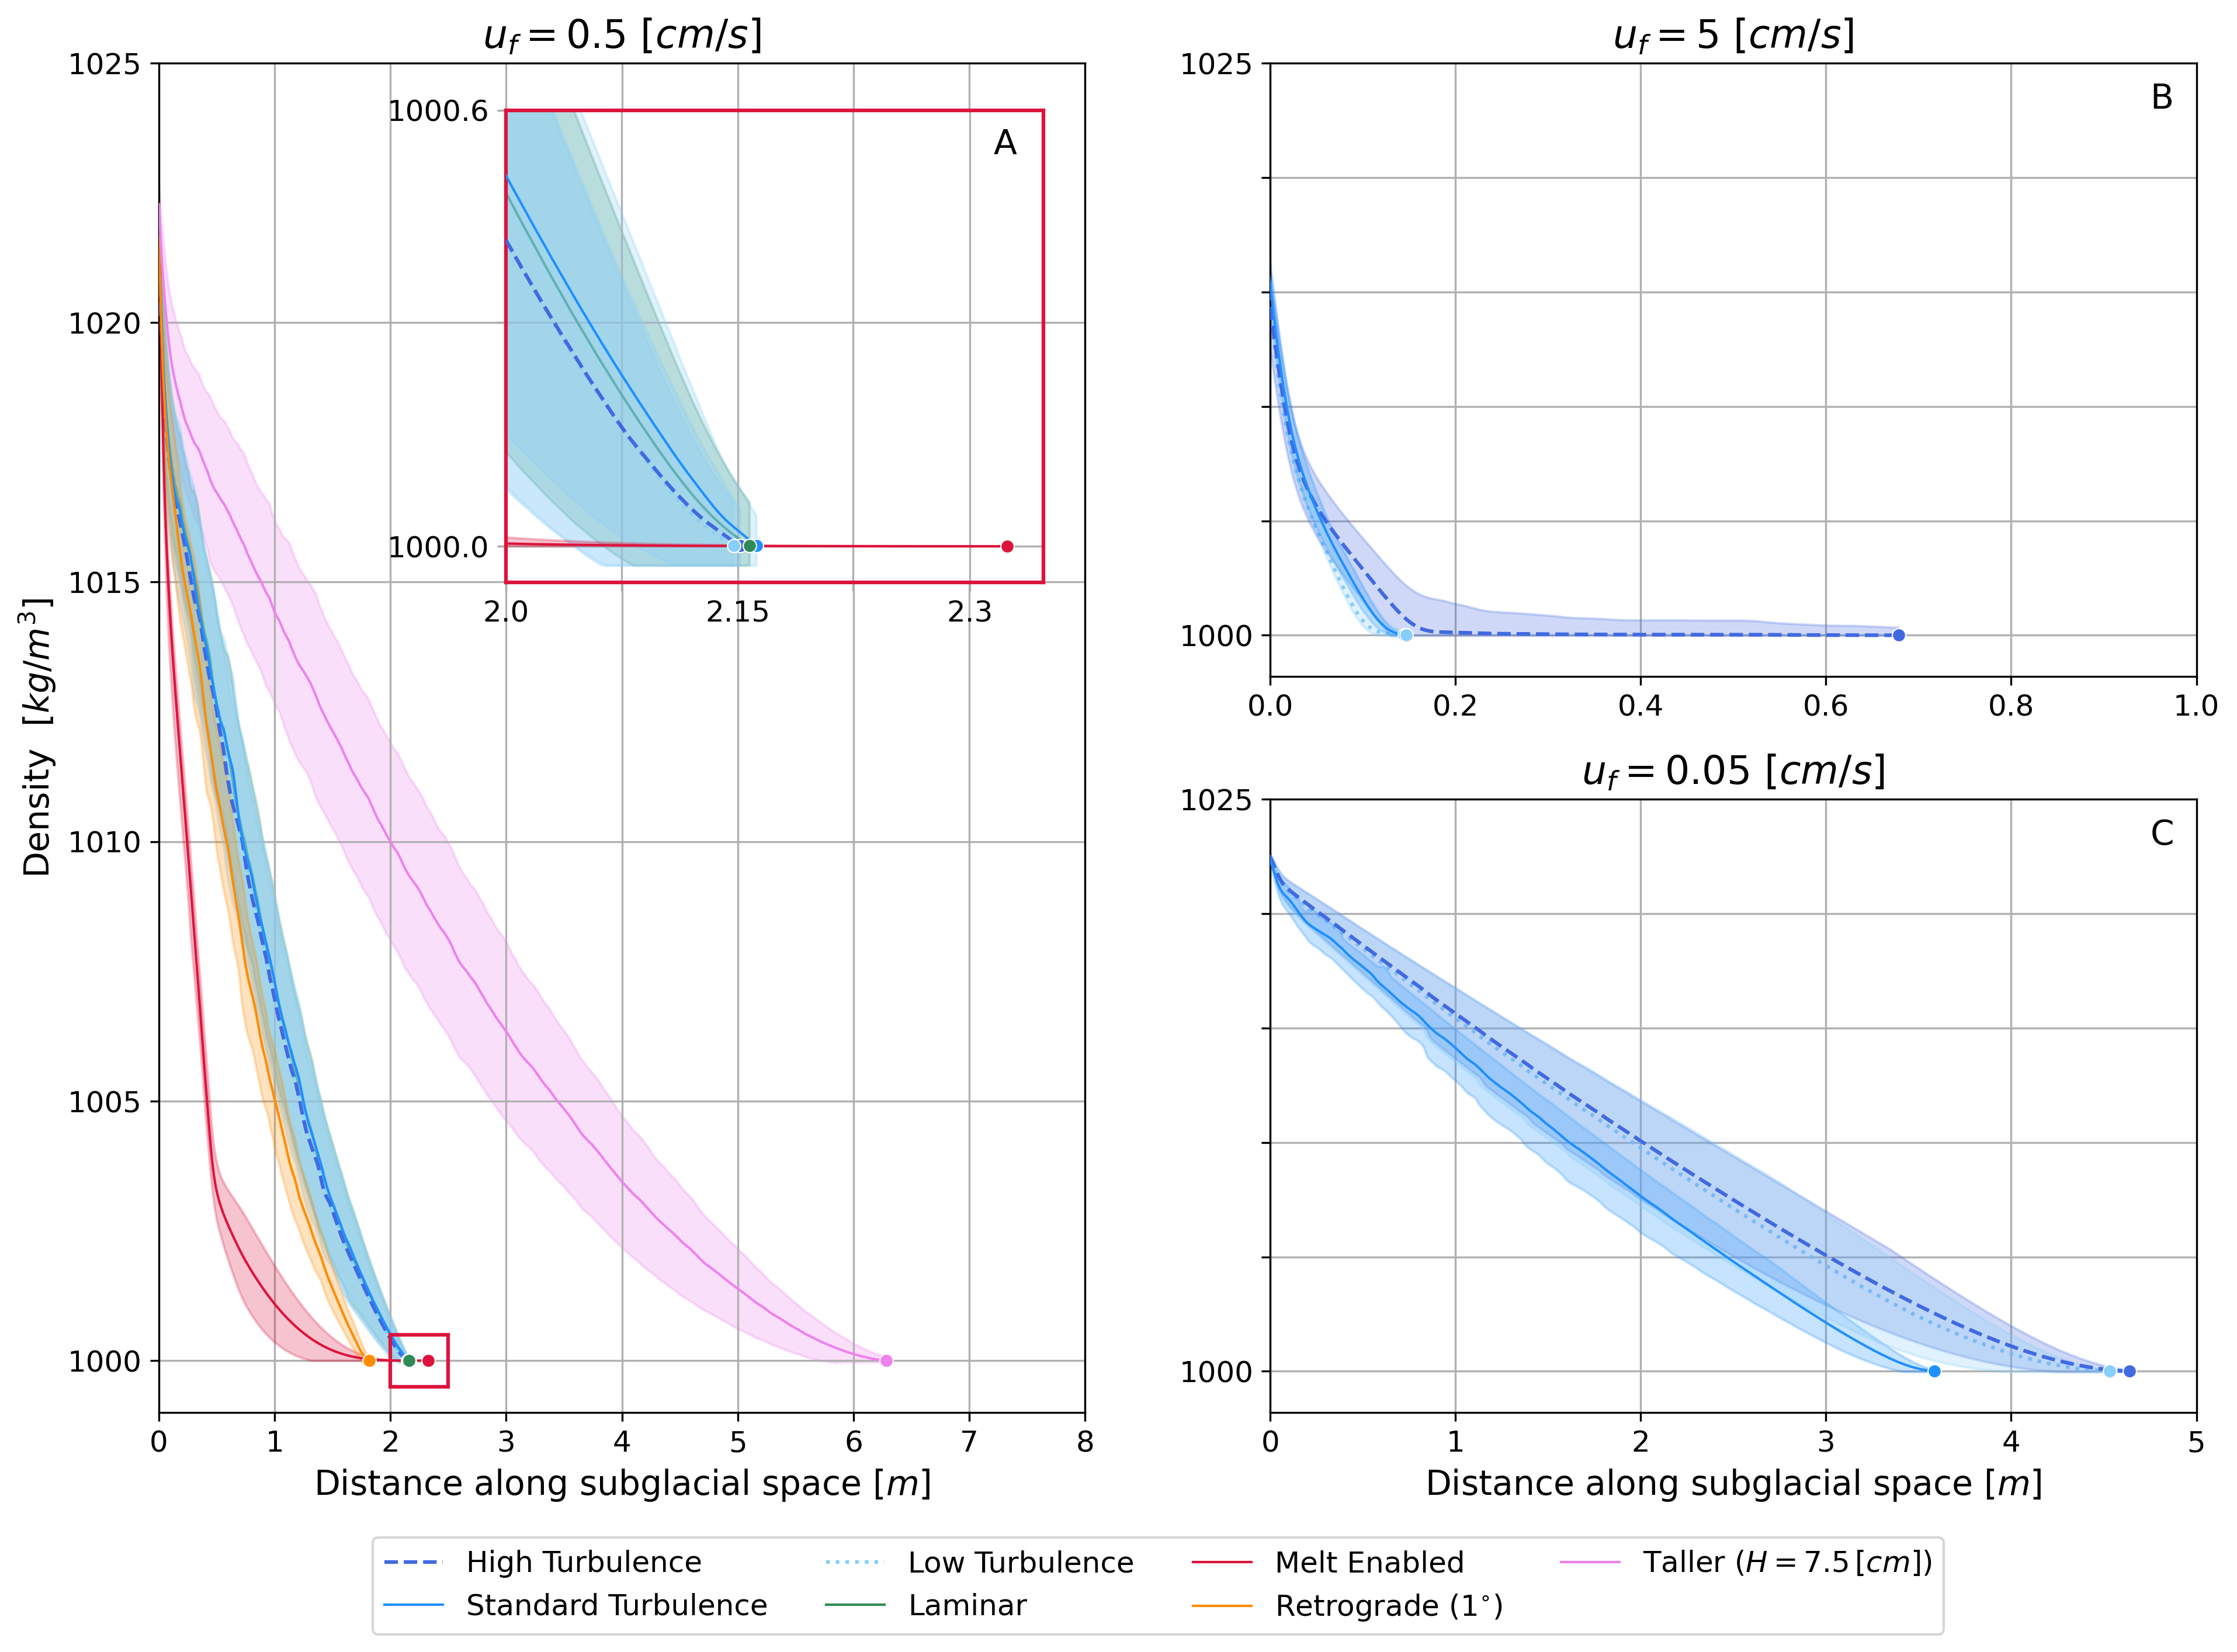

In [13]:
cmap = ['royalblue','dodgerblue','lightskyblue', 'crimson', 'darkorange','violet' ,'seagreen']
## high turb, med turb,low turb, bf, slanted, and thicker

fig = plt.figure(figsize=(15,10), dpi = 300)
spec = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(spec[:, 0])

ax2 = fig.add_subplot(spec[0, 1])

ax3 = fig.add_subplot(spec[1, 1])

# #------------------------------------------------------------------------------#
# ## ax1 plotting - F2 cases u_f = 0.5 cm/s

high,  = ax1.plot(F2cu1_intru['x'], F2cu1_intru['mean'], color = cmap[0], zorder = 3, linestyle = '--', label = 'High');   # Cu = 0.18
std,   = ax1.plot(F2cu2_intru['x'], F2cu2_intru['mean'], color = cmap[1], zorder = 3, linewidth = 1, label = 'Standard');  # Cu = 0.09
low,   = ax1.plot(F2cu3_intru['x'], F2cu3_intru['mean'], color = cmap[2], zorder = 2, linestyle = ':', label = 'low');     # Cu = 0.045
bf,    = ax1.plot(F2cu2_intru_bf['x'], F2cu2_intru_bf['mean'], color = cmap[3], zorder = 3, linewidth = 1, label = 'BF');  # Cu = 0.09, melting enabled
slant, = ax1.plot(F4cu2_intru['x'], F4cu2_intru['mean'], color = cmap[4], zorder = 3, linewidth = 1, label = 'Slanted');   # Cu = 0.09, retrograde slope theta = -0.5
thick, = ax1.plot(F5cu2_intru['x'], F5cu2_intru['mean'], color = cmap[5], zorder = 3, linewidth = 1, label = 'Thicker');   # Cu = 0.09, thicker opening h = 0.075 m
lam,   = ax1.plot(F2_lam_intru['x'], F2_lam_intru['mean'], color = cmap[6], zorder = 2, linewidth = 1, linestyle = '-');   # Laminar case


ax1.fill_between(F2cu1_intru['x'], F2cu1_intru['plus'], F2cu1_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])
ax1.fill_between(F2cu2_intru['x'], F2cu2_intru['plus'], F2cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])
ax1.fill_between(F2cu3_intru['x'], F2cu3_intru['plus'], F2cu3_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])
ax1.fill_between(F2cu2_intru_bf['x'], F2cu2_intru_bf['plus'], F2cu2_intru_bf['minus'], alpha = 0.25, zorder = 2, color = cmap[3])
ax1.fill_between(F4cu2_intru['x'], F4cu2_intru['plus'], F4cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[4])
ax1.fill_between(F5cu2_intru['x'], F5cu2_intru['plus'], F5cu2_intru['minus'], alpha = 0.25, zorder = 1, color = cmap[5])
ax1.fill_between(F2_lam_intru['x'], F2_lam_intru['plus'], F2_lam_intru['minus'], alpha = 0.25, zorder = 1, color = cmap[6])


ax1.scatter(F2cu1_intru['x'].iloc[-1],F2cu1_intru['mean'].iloc[-1], color = cmap[0], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax1.scatter(F2cu2_intru['x'].iloc[-1],F2cu2_intru['mean'].iloc[-1], color = cmap[1], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax1.scatter(F2cu3_intru['x'].iloc[-1],F2cu3_intru['mean'].iloc[-1], color = cmap[2], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax1.scatter(F2cu2_intru_bf['x'].iloc[-1],F2cu2_intru_bf['mean'].iloc[-1], color = cmap[3], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax1.scatter(F4cu2_intru['x'].iloc[-1],F4cu2_intru['mean'].iloc[-1], color = cmap[4], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);       
ax1.scatter(F5cu2_intru['x'].iloc[-1],F5cu2_intru['mean'].iloc[-1], color = cmap[5], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax1.scatter(F2_lam_intru['x'].iloc[-1],F2_lam_intru['mean'].iloc[-1], color = cmap[6], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);


# # #------------------------------------------------------------------------------#
# # ## ax2 plotting - F1 cases u_f = 5 cm/s

ax2.plot(F1cu1_intru['x'], F1cu1_intru['mean'], color = cmap[0], zorder = 3, linestyle = '--');
ax2.plot(F1cu2_intru['x'], F1cu2_intru['mean'], color = cmap[1], zorder = 3, linewidth = 1);
ax2.plot(F1cu3_intru['x'], F1cu3_intru['mean'], color = cmap[2], zorder = 2, linestyle = ':');

ax2.fill_between(F1cu1_intru['x'], F1cu1_intru['plus'], F1cu1_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[0])
ax2.fill_between(F1cu2_intru['x'], F1cu2_intru['plus'], F1cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[1])
ax2.fill_between(F1cu3_intru['x'], F1cu3_intru['plus'], F1cu3_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])

ax2.scatter(F1cu1_intru['x'].iloc[-1],F1cu1_intru['mean'].iloc[-1], color = cmap[0], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax2.scatter(F1cu2_intru['x'].iloc[-1],F1cu2_intru['mean'].iloc[-1], color = cmap[1], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax2.scatter(F1cu3_intru['x'].iloc[-1],F1cu3_intru['mean'].iloc[-1], color = cmap[2], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

# # #------------------------------------------------------------------------------#
# # ## ax3 plotting - F3 cases u_f = 0.05 cm/s

ax3.plot(F3cu1_intru['x'], F3cu1_intru['mean'], color = cmap[0], zorder = 3, linestyle = '--');
ax3.plot(F3cu2_intru['x'], F3cu2_intru['mean'], color = cmap[1], zorder = 3, linewidth = 1);
ax3.plot(F3cu3_intru['x'], F3cu3_intru['mean'], color = cmap[2], zorder = 2, linestyle = ':');

ax3.fill_between(F3cu1_intru['x'], F3cu1_intru['plus'], F3cu1_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[0])
ax3.fill_between(F3cu2_intru['x'], F3cu2_intru['plus'], F3cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[1])
ax3.fill_between(F3cu3_intru['x'], F3cu3_intru['plus'], F3cu3_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])

ax3.scatter(F3cu1_intru['x'].iloc[-1], F3cu1_intru['mean'].iloc[-1], color = cmap[0], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax3.scatter(F3cu2_intru['x'].iloc[-1], F3cu2_intru['mean'].iloc[-1], color = cmap[1], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
ax3.scatter(F3cu3_intru['x'].iloc[-1], F3cu3_intru['mean'].iloc[-1], color = cmap[2], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

# # #------------------------------------------------------------------------------#
# ## Inset axis

axin = ax1.inset_axes([0.375, 0.615, 0.58, 0.35])
high,  = axin.plot(F2cu1_intru['x'], F2cu1_intru['mean'], color = cmap[0], zorder = 3, linestyle = '--', label = 'High');   # Cu = 0.18
std,   = axin.plot(F2cu2_intru['x'], F2cu2_intru['mean'], color = cmap[1], zorder = 3, linewidth = 1, label = 'Standard');  # Cu = 0.09
low,   = axin.plot(F2cu3_intru['x'], F2cu3_intru['mean'], color = cmap[2], zorder = 2, linestyle = ':', label = 'low');     # Cu = 0.045
bf,    = axin.plot(F2cu2_intru_bf['x'], F2cu2_intru_bf['mean'], color = cmap[3], zorder = 3, linewidth = 1, label = 'BF');  # Cu = 0.09, melting enabled
lam,   = axin.plot(F2_lam_intru['x'], F2_lam_intru['mean'], color = cmap[6], zorder = 2, linewidth = 1, linestyle = '-');   # Laminar case
slant, = axin.plot(F4cu2_intru['x'], F4cu2_intru['mean'], color = cmap[4], zorder = 3, linewidth = 1, label = 'Slanted');   # Cu = 0.09, retrograde slope theta = -0.5

axin.fill_between(F2cu1_intru['x'], F2cu1_intru['plus'], F2cu1_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])
axin.fill_between(F2cu2_intru['x'], F2cu2_intru['plus'], F2cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])
axin.fill_between(F2cu3_intru['x'], F2cu3_intru['plus'], F2cu3_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[2])
axin.fill_between(F2cu2_intru_bf['x'], F2cu2_intru_bf['plus'], F2cu2_intru_bf['minus'], alpha = 0.25, zorder = 2, color = cmap[3])
axin.fill_between(F2_lam_intru['x'], F2_lam_intru['plus'], F2_lam_intru['minus'], alpha = 0.25, zorder = 1, color = cmap[6])
axin.fill_between(F4cu2_intru['x'], F4cu2_intru['plus'], F4cu2_intru['minus'], alpha = 0.25, zorder = 1, color = cmap[4]);   # Cu = 0.09, retrograde slope theta = -0.5

axin.scatter(F2cu1_intru['x'].iloc[-1],F2cu1_intru['mean'].iloc[-1], color = cmap[0], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
axin.scatter(F2cu2_intru['x'].iloc[-1],F2cu2_intru['mean'].iloc[-1], color = cmap[1], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
axin.scatter(F2cu3_intru['x'].iloc[-1],F2cu3_intru['mean'].iloc[-1], color = cmap[2], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
axin.scatter(F2cu2_intru_bf['x'].iloc[-1],F2cu2_intru_bf['mean'].iloc[-1], color = cmap[3], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
axin.scatter(F2_lam_intru['x'].iloc[-1],F2_lam_intru['mean'].iloc[-1], color = cmap[6], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);
axin.scatter(F4cu2_intru['x'].iloc[-1], F4cu2_intru['mean'].iloc[-1], color = cmap[4], zorder = 4, s = 30, edgecolor = 'white', linewidth = 0.5);   # Cu = 0.09, retrograde slope theta = -0.5

axin.spines['bottom'].set_color('darkgray')
axin.spines['top'].set_color('darkgray') 
axin.spines['right'].set_color('darkgray')
axin.spines['left'].set_color('darkgray')

axin.tick_params(axis = 'x', color = 'darkgray')
axin.tick_params(axis = 'y', color = 'darkgray')
#------------------------------------------------------------------------------#
# ax1.text(0.81,1000.5,s = 'Re = 2400',fontsize = 14, fontweight = 'bold')
# ax2.text(14.5,1000.5,s = 'Re = 240',fontsize = 14, fontweight = 'bold')
# ax3.text(0.7,1000.5,s = 'Re = 24',fontsize = 14, fontweight = 'bold')

ax1.grid(zorder=1); ax2.grid(zorder=1); ax3.grid(zorder=1); axin.grid(zorder=1);

ax1.set_ylim(999,1025); ax2.set_ylim(998.2,1025); ax3.set_ylim(998.2,1025); axin.set_ylim(999.95,1000.6); 

ax1.set_xlim(0,8); ax2.set_xlim(0,1); ax3.set_xlim(0,5); axin.set_xlim(2,2.35);
ax3.set_yticks([1000,1005,1010,1015,1020,1025]); ax2.set_yticks([1000,1005,1010,1015,1020,1025]); 
axin.set_yticks([1000,1000.308, 1000.6]); axin.set_yticklabels([1000.0,'' ,1000.6])
axin.set_xticks([2, 2.075, 2.151, 2.226, 2.302]); axin.set_xticklabels([2.0,'',2.15, '', 2.3]);
[x.set_linewidth(1.5) for x in axin.spines.values()]
[x.set_color('crimson') for x in axin.spines.values()]
rect = patches.Rectangle((2, 999.5), 0.5, 1, linewidth=1.5, edgecolor='crimson', facecolor = 'none', zorder = 3)
ax1.add_patch(rect)
ax3.set_yticklabels(['1000','','','','','1025']); ax2.set_yticklabels(['1000','','','','','1025'])

ax1.set_title('$u_{f} = 0.5 \,\, [cm/s]$'); 
ax2.set_title('$u_{f} = 5\,\, [cm/s]$'); 
ax3.set_title('$u_{f} = 0.05\,\, [cm/s]$');

ax3.set_xlabel('Distance along subglacial space $[m]$'); 
ax1.set_xlabel('Distance along subglacial space $[m]$')
ax1.set_ylabel('Density $\, \, [kg/m^3]$')
legend = fig.legend([high, std, low, lam, bf, slant, thick],['High Turbulence','Standard Turbulence','Low Turbulence','Laminar','Melt Enabled',\
                                                      'Retrograde ($1^{\circ}$)', 'Taller ($H = 7.5 \, [cm]$)'],ncol=4,fontsize = 12, loc = 8, bbox_to_anchor = [0.505,-0.025]);
# legend = fig.legend([high, std, low, lam, bf],['High Turbulence','Standard Turbulence','Low Turbulence','Laminar','Melt Enabled'],\
#                                                        ncol=4,fontsize = 12, loc = 8, bbox_to_anchor = [0.505,-0.025]);

axin.text(2.3175,1000.54,'A',fontsize = 14); 
ax2.text(0.95, 1023, 'B',fontsize = 14); 
ax3.text(4.75,1023,'C',fontsize = 14)
fig.savefig('densityProfs.png', dpi = 500, facecolor = 'white')

### Plotting Wilson 2020 experimental data against the Fluent Intrusion data

The majority of this code is borrowed from Earle Wilson. You will need the pickle_data file for it to run correctly.

/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_40239/4186665247.py:564: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, h, j, intru[i] = intrusion(Fr0[i],Ci,Cd,theta,gamma)


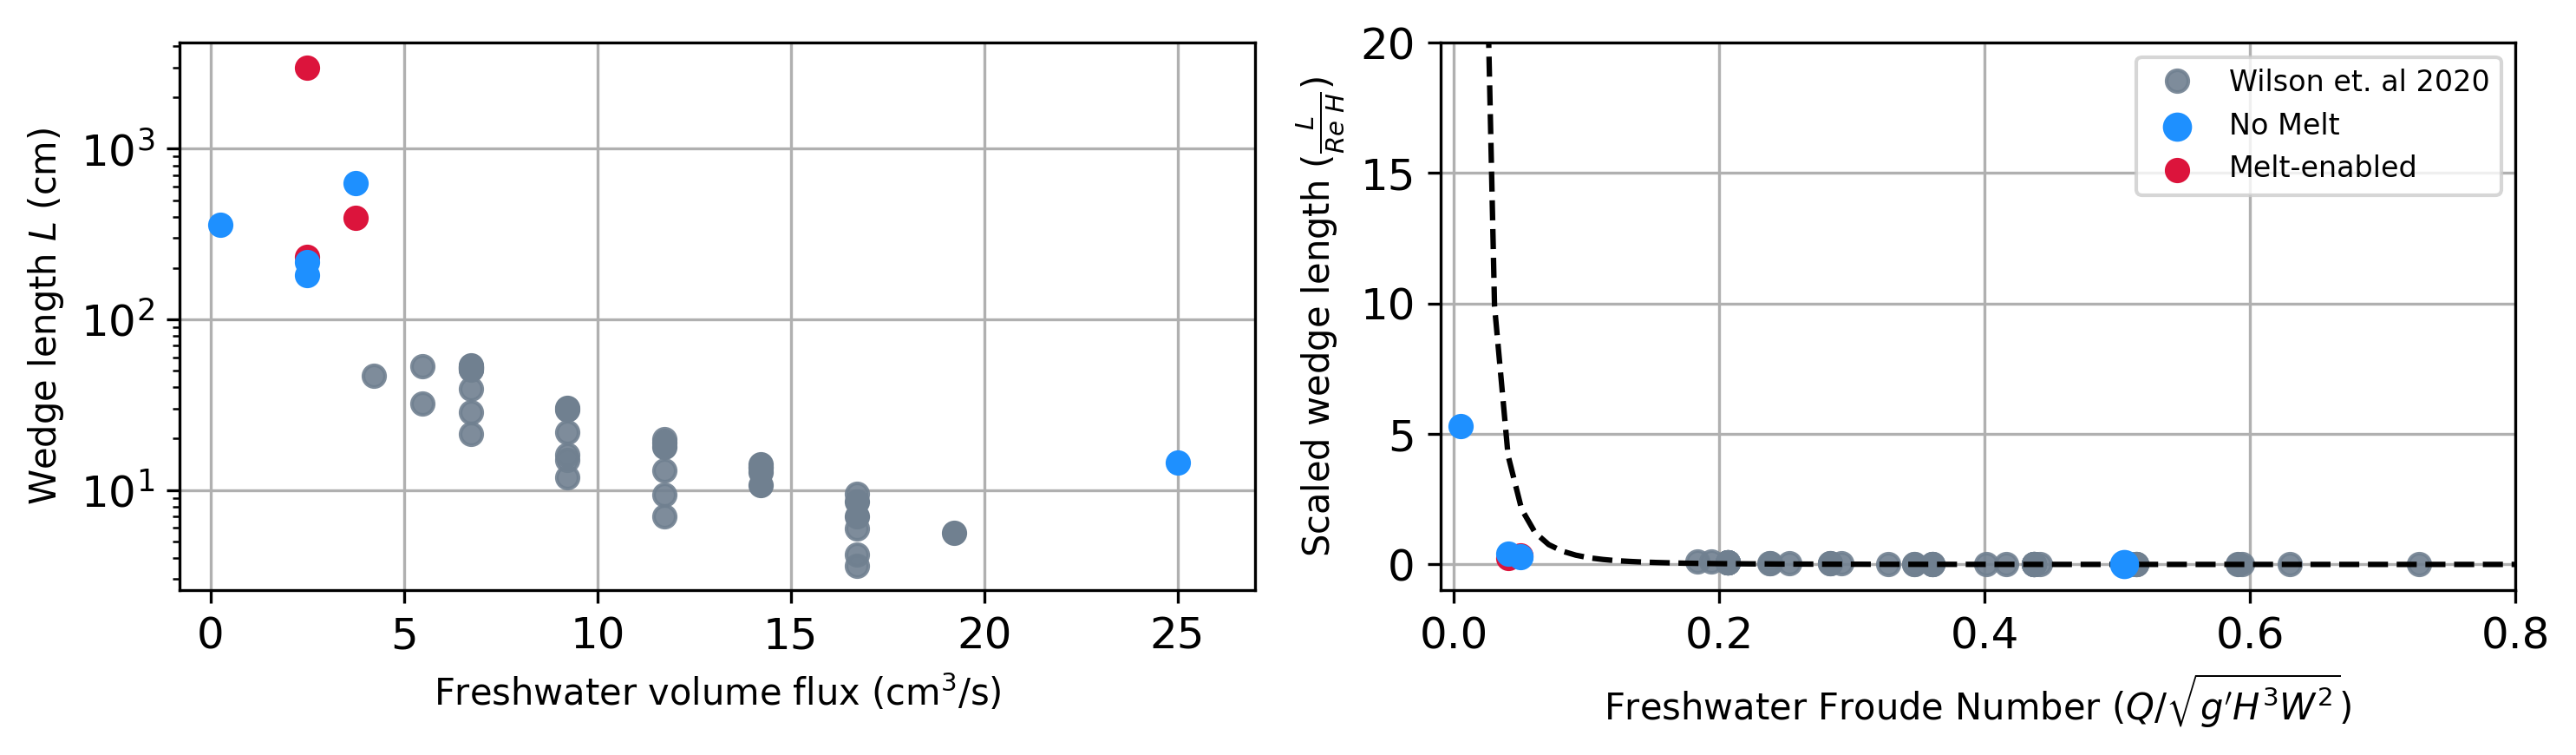

In [6]:
###### Below this line code and data is provided by Earle Wilson from Wilson et al. 2020 ######

def get_vol_flux(pump_setting):
    """ Function that converts pump setting to volume flux (cm3/s)
        Pump: ISNATEC BVP=Z
        Pump head serial #: 884519
    """

    return pump_setting * 0.05 - 0.78


def get_run_params(run_name):
    
    video_dir = "/Users/ewilson2011/Desktop/Lab_videos/"

    run_params = {}
    run_dir = run_name[:-1]
    run_num = run_name.split('_')[-1]

    if run_name == 'july14_run1':
        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(100 * run_params['a'], 1200 * run_params['a'])
        run_params['y_r'] = slice(200 * run_params['b'], 330 * run_params['b'])
        run_params['tube_x0_p'] = 20  # left edge of tube (pixels)
        run_params['w_x0_p'] = 70  # pixels
        run_params['tube_y0_p'] = 190  # base of tube (pixels)
        run_params['tube_h_p'] = 65  # tube height in pixels
        run_params['ri_thresh'] = 0.01  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 20  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -12  # correction factor for thickness of tube (pixels)
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([30, 180, 260, 370, 480, 860])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 10
        run_params['pump_set'] = np.array([350, 300, 250, 200, 150])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 55
        run_params['ds'] = 33 # salintiy difference
        run_params['tilt_fix'] = 0.65 # slope error adjustment
        run_params['tube_slope'] = 0

    elif run_name == 'july17_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(50 * run_params['a'], 1200 * run_params['a'])
        run_params['y_r'] = slice(150 * run_params['b'], 280 * run_params['b'])
        run_params['tube_x0_p'] = 15  # pixels
        run_params['w_x0_p'] = 30  # pixels
        run_params['tube_y0_p'] = 103 * run_params['b']  # pixels
        run_params['tube_h_p'] = 75  # pixels
        run_params['ri_thresh'] = 0.02  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 20  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -9  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([200, 390, 635, 840, 975, 1085, 1200])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 10
        run_params['t_eq'][-1] = 1200
        run_params['pump_set'] = np.array([150, 200, 250, 300, 350, 400])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 50
        run_params['tilt_fix'] = -0.2
        run_params['ds'] = 33
        run_params['tube_slope'] = 0

    elif run_name == 'july20_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(20 * run_params['a'], 1190 * run_params['a'])
        run_params['y_r'] = slice(150 * run_params['b'], 280 * run_params['b'])
        run_params['tube_x0_p'] = 20  # pixels
        run_params['w_x0_p'] = 40
        run_params['tube_y0_p'] = 190  # pixels
        run_params['tube_h_p'] = 80  # pixels
        run_params['ri_thresh'] = 0.15  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 20  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -13  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 100, 365, 8 * 60 + 20, 15 * 60 + 35,
                                           17 * 60 + 55, 21 * 60 + 25])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([300, 150, 300, 150, 300, 150])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['tilt_fix'] = 0.2
        run_params['ds'] = 33
        run_params['tube_slope'] = 0

    elif run_name == 'july21_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(0 * run_params['a'], 1160 * run_params['a'])
        run_params['y_r'] = slice(150 * run_params['b'], 280 * run_params['b'])
        run_params['tube_x0_p'] = 0  # pixels
        run_params['w_x0_p'] = 25
        run_params['tube_y0_p'] = 195  # pixels
        run_params['tube_h_p'] = 73  # pixels
        run_params['ri_thresh'] = 0.2  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -11  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 8*60, 17*60 + 10, 19*60 + 15, 23*60+50])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([150, 250, 350, 150])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33
        run_params['tilt_fix'] = 0.1

    elif run_name == 'july24_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(150 * run_params['b'], 280 * run_params['b'])
        run_params['tube_x0_p'] = 0  # pixels
        run_params['w_x0_p'] = 40
        run_params['tube_y0_p'] = 95 * run_params['b']  # pixels
        run_params['tube_h_p'] = 77  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -5 * run_params['b']  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 145, 305, 545, 715, 930, 1080])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([350, 250, 200, 150, 100, 125])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33./2
        run_params['tilt_fix'] = 0.1

    elif run_name == 'july25_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 50  # pixels
        run_params['w_x0_p'] = 75
        run_params['tube_y0_p'] = 185  # pixels
        run_params['tube_h_p'] = 75  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -5 * run_params['b']  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' %(run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 155, 310, 425, 610, 825])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([350, 250, 200, 150, 125])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33*(3/4)
        run_params['tilt_fix'] = -0.6

    elif run_name == 'july28_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 140  # pixels
        run_params['w_x0_p'] = 194
        run_params['tube_y0_p'] = 177  # pixels
        run_params['tube_h_p'] = 80  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -5 * run_params['b']  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' %(run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 135, 285, 665])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([350, 250, 200])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33*(2/3)
        run_params['tilt_fix'] = 0

    elif run_name == 'july28_run2':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 395  # pixels
        run_params['w_x0_p'] = 395
        run_params['tube_y0_p'] = 132  # pixels
        run_params['tube_h_p'] = 77  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -5 * run_params['b']  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 40, 495])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([200, 150])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33*(2/3)
        run_params['tilt_fix'] = 0

    elif run_name == 'july31_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 30  # pixels
        run_params['w_x0_p'] = 50
        run_params['tube_y0_p'] = 120  # pixels
        run_params['tube_h_p'] = 80  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -15  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 169, 360, 900])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([350, 300, 250])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33
        run_params['tilt_fix'] = 0
        run_params['tube_slope'] = 0.9

    elif run_name == 'aug04_run4':

        run_params['a'] = 2
        run_params['b'] = 2
        # run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        # run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        # run_params['tube_x0_p'] = 70  # pixels
        # run_params['tube_y0_p'] = 185  # pixels
        # run_params['tube_h_p'] = 75  # pixels
        # run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        # run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        # run_params['base_offset_pix'] = -5 * run_params['b']  # pixels
        # run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        # run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        # run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        # run_params['im_dt'] = 5  # time interval of each image
        # run_params['t_switch'] = np.array([0, 4*60+50])  # instances when pump speed changes
        # run_params['t_eq'] = run_params['t_switch'][1:] - 5
        # run_params['pump_set'] = np.array([600, 550])
        # run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        # run_params['x_cut_off_cm'] = 68
        # run_params['ds'] = 33
        # run_params['tilt_fix'] = -0.6

    elif run_name == 'aug09_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 125  # pixels
        run_params['w_x0_p'] = 150
        run_params['tube_y0_p'] = 150  # pixels
        run_params['tube_h_p'] = 75  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -20  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 360, 560, 715])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([450, 500, 550])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33
        run_params['tilt_fix'] = 0
        run_params['tube_slope'] = 3.3

    elif run_name == 'aug09_run2':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 150  # pixels
        run_params['w_x0_p'] = 180
        run_params['tube_y0_p'] = 177  # pixels
        run_params['tube_h_p'] = 75  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -20  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 160, 295, 445, 600, 1035])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([550, 500, 450, 400, 350])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33
        run_params['tilt_fix'] = 0
        run_params['tube_slope'] = 2.2

    elif run_name == 'aug10_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 45  # pixels
        run_params['w_x0_p'] = 90
        run_params['tube_y0_p'] = 160  # pixels
        run_params['tube_h_p'] = 80  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -15  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 150, 250, 345, 445, 615, 830])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([500, 450, 400, 350, 300, 250])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33
        run_params['tilt_fix'] = -0.6#-0.5
        run_params['tube_slope'] = 0.4#1.2

    elif run_name == 'aug11_run1':

        run_params['a'] = 2
        run_params['b'] = 2
        run_params['x_r'] = slice(5 * run_params['a'], 1155 * run_params['a'])
        run_params['y_r'] = slice(175 * run_params['b'], 305 * run_params['b'])
        run_params['tube_x0_p'] = 85  # pixels
        run_params['tube_y0_p'] = 160  # pixels
        run_params['tube_h_p'] = 80  # pixels
        run_params['ri_thresh'] = 0.12  # upper bound of red channel intensity within FW layer
        run_params['ri_thresh_minL'] = 50  # number of consecutive pixels to satisfy run_params['ri_thresh'] criteria
        run_params['base_offset_pix'] = -15  # pixels
        run_params['frames_dir'] = video_dir + '%s/%s/rotated_rz_frames/' % (run_dir, run_num)
        run_params['run_dir'] = video_dir + '%s/%s/' % (run_dir, run_num)
        run_params['max_w_p'] = 1000 * run_params['a']  # pixels
        run_params['im_dt'] = 5  # time interval of each image
        run_params['t_switch'] = np.array([0, 150, 250, 345, 445, 615, 830])  # instances when pump speed changes
        run_params['t_eq'] = run_params['t_switch'][1:] - 5
        run_params['pump_set'] = np.array([550, 570])
        run_params['pump_flux'] = get_vol_flux(run_params['pump_set'])
        run_params['x_cut_off_cm'] = 68
        run_params['ds'] = 33
        run_params['tilt_fix'] = -1.2
        run_params['tube_slope'] = 7.8


    return run_params

flat_lab_runs = ['july14_run1', 'july17_run1', 'july20_run1', 'july21_run1', 'july24_run1', 'july25_run1',
                 'july28_run1', 'july28_run2']
sloped_lab_runs = ['july31_run1', 'aug09_run1', 'aug09_run2', 'aug10_run1']

all_lab_runs = flat_lab_runs + sloped_lab_runs

# fig control
ms = 6
alpha = 0.9
fz=10
add_model_curves=True

# constants
w0 = 2.1
h0 = 2.1
beta = 0.8e-3  # 1/psu
g = 9.81 * 100  # cm/s2
nu = 1e-2 #cm2/s
C0 = 1
fullSW=False

# load lab runs with flat channel
slope='flat'

lab_run_stats_all = pickle.load(open('pickle_files/lab_run_stats_all.p', 'rb'))
lab_run_stats = {run_name: lab_run_stats_all[run_name] 
                 for run_name in all_lab_runs if run_name in flat_lab_runs}

run_names = list(lab_run_stats.keys())
angle_str = '_%s' %slope

ds_list = np.array([get_run_params(run_name)['ds'] for run_name in run_names])
sort_i = np.argsort(ds_list)
run_names_sorted = np.array(run_names)[sort_i][::-1]

colors = ['slategray', 'slategray','slategray', 'maroon',  'darkblue']

ii=0
jj = 0
flat_data = {'Fr0': [], 'wlen_scaled': []}

fig, axes = plt.subplots(1,2, figsize=(10, 3), dpi = 300)
axes = axes.flatten()

for run_name in run_names_sorted:

    run_params = get_run_params(run_name)

    if fullSW and run_params['ds']!= 33:
        continue


    # get tube slope
    if 'tube_slope' in run_params:
        theta = run_params['tube_slope']
    else:
        theta = 0


    if run_params['ds'] == 33 and theta==0:
        ls = 'o'
    elif run_params['ds'] != 33 and theta==0:
        ls = 'o'
    elif run_params['ds'] != 33 and theta>0:
        ls = 'o'
    elif theta>0:
        ls = 'o'

    # plot sorted pump speeds
    lab_run = lab_run_stats[run_name]
    pset_sort_i = np.argsort(run_params['pump_set'])
    q0 = run_params['pump_flux'][pset_sort_i]
    w_len_eq = lab_run["w_len_eq"][pset_sort_i]

    Fr0 = q0 / np.sqrt(g * beta * lab_run['ds'] * w0 ** 2 * h0 ** 3)
    Re = q0/(h0*nu)

    gp = 9.81*beta*lab_run['ds'] 

    sf = 1/(Re*h0)
    if run_name=='july21_run1' or run_params['ds'] != 33 or theta>0:

        if run_params['ds'] == 33 and theta==0:
            col = 'slategray'

        elif run_name.startswith('july28'):
            col = 'slategray'

        else:
            col = colors[jj]
            jj  = jj+1

        if col=='k':
            mfc = 'slategray'
        else:
            mfc = col


        if run_name=='july28_run2':
            # TODO: find a better way to do this
            earle, = axes[0].plot(q0, w_len_eq, ls, markersize=ms, linewidth=2, alpha=alpha, color=col, markerfacecolor=col)

            earle, = axes[1].plot(Fr0, w_len_eq*sf, ls, markersize=ms, linewidth=2, alpha=alpha, color=col, markerfacecolor=col, zorder = 2)

        else:
            axes[0].plot(q0, w_len_eq, ls, markersize=ms, linewidth=2, alpha=alpha, color=col, markerfacecolor=col)

            axes[1].plot(Fr0, w_len_eq*sf, ls, markersize=ms, linewidth=2, alpha=alpha, color=col, markerfacecolor=col, zorder = 2)

    else:
        axes[0].plot(q0, w_len_eq, ls, markersize=ms, linewidth=2, color=col, markerfacecolor=col)
        #axes[1].plot(pump_setting, w_len_eq, ls, markersize=ms, linewidth=2)

        axes[1].plot(Fr0, w_len_eq*sf, ls, markersize=ms, linewidth=2, color=col, markerfacecolor=col, zorder = 2)

    ii = ii + 1

    wlen_scaled =  w_len_eq*sf
    for kk in range(len(Fr0)):

        flat_data['Fr0'].append(Fr0[kk])
        flat_data['wlen_scaled'].append(wlen_scaled[kk])


if add_model_curves:
    dS_vec = [33]
    ls = ['--', ':']
    curve_str = '_w_curves'
    for jj, dS in enumerate(dS_vec):
        md = pickle.load(open('pickle_files/fig_data_L_vs_Fr_dS%s.p' %dS, 'rb'))
        Re = md['q0_vec']/(h0*nu)
        #axes[1].plot(md['Fr0_vec'], md['wlen']/(h0*Re), ls=ls[jj], color='k', label='$\Delta S$ =%s PSU' %dS)

    flat_data['Fr0_mod'] = md['Fr0_vec'] 
    flat_data['wlen_scaled_mod'] = md['wlen']/(h0*Re)

    pickle.dump(flat_data, open('fig6_plot_data.p', 'wb'))
    #debug_here()
else:
    curve_str = ''

##### Below this line code is written by madeline mamer mmamer3@gatech.edu #######


### theory black dashed line ###
def intrusion(Fr0,Ci,Cd,theta,gamma):
    h=np.empty([100000, 1])
    x=np.empty([100000, 1])
    #Initial conditions
    h[0] = Fr0**(2/3)
    x[0] = 0
    i=0
    int=1e16
    while h[i] < 1: #stop when freshwater occupies entire layer
        dx = 1e-16 + (1e-1-1e-16)*np.tanh(-1/int)
        #start with very small O(machine precision) grid spacing and then increase as gradient decreases
        if i==0 :
            Fr = 1 - 1e-8  #avoid singularity due to Fr=1 at boundary while maintaining accuracy (has been tested for sensitivity)
        else:
            Fr = Fr0/(h[i]**1.5)
            
        int = ((Fr**2)*((Ci/(1-h[i])) + Cd*(1+gamma*h[i])) - theta)/(Fr**2 - 1)
    
        h[i+1] = h[i] - dx*int
        x[i+1] = x[i] - dx
        i = i+1;
        if i > 100000-2:
            break
    return x, h, i, x[i]

us = np.linspace(0.00001,0.1,100);
intru = np.zeros(len(us));
Fr0 = np.zeros(len(us));

for i in range(0,len(us)):
    u = us[i]
    H = 0.05
    W = 1
    gprime = 0.2
    Fr0[i] = (u * H * W) / (np.sqrt(gprime * H**3 * W**2));
    Ci = 1;
    Cd = 1;
    theta = 0;
    gamma = 0.015;
    x, h, j, intru[i] = intrusion(Fr0[i],Ci,Cd,theta,gamma)
    

### scaling Fluent intrusion lengths ###
def scaling(u, L, H):
    
    gprime = 9.8 * (20/1000)
    W = 1
    nu = 18.43 * 10 **(-7)
    Dh = (2 * H * W) / (H + W)
    Re = u * H / nu
    q = u * H * W / (np.sqrt(gprime * H**3 * W**2))
    scaleLen = L / (Re * H)
    Cd = 7/Re
    return q, scaleLen, Cd

fr0, sLen, Cd = scaling(us,abs(intru), H = 0.05)
axes[1].plot(fr0, sLen, color = 'black', linestyle = '--', zorder = 2); 

fr0_f1cu2, sLen_f1cu2, Cd_f1cu2 = scaling(0.05, F1cu2_intru['x'].iloc[-1], 0.05);
fr0_f2cu2, sLen_f2cu2, Cd_f2cu2 = scaling(0.005, F2cu2_intru['x'].iloc[-1], 0.05);
fr0_f3cu2, sLen_f3cu2, Cd_f3cu2 = scaling(0.0005, F3cu2_intru['x'].iloc[-1], 0.05);
fr0_f4cu2, sLen_f4cu2, Cd_f4cu2 = scaling(0.005, F4cu2_intru['x'].iloc[-1], 0.05);
fr0_f5cu2, sLen_f5cu2, Cd_f5cu2 = scaling(0.005, F5cu2_intru['x'].iloc[-1], 0.075);

fr0_bf_f2cu2, sLen_bf_f2cu2, Cd_bf_f2cu2 = scaling(0.005, F2cu2_intru_bf['x'].iloc[-1], 0.05);
fr0_bf_f4cu2, sLen_bf_f4cu2, Cd_bf_f4cu2 = scaling(0.0005, F4cu2_intru_bf['x'].iloc[-1], 0.05);
fr0_bf_f5cu2, sLen_bf_f5cu2, Cd_bf_f5cu2 = scaling(0.005, F5cu2_intru_bf['x'].iloc[-1], 0.075);


noMelt = axes[1].scatter(fr0_f1cu2,sLen_f1cu2, color = 'dodgerblue', marker = 'o', zorder = 3, s = 50)
axes[1].scatter(fr0_f2cu2,sLen_f2cu2, color = 'dodgerblue', marker = 'o',zorder = 3)
axes[1].scatter(fr0_f3cu2,sLen_f3cu2, color = 'dodgerblue', marker = 'o',zorder = 3)
axes[1].scatter(fr0_f4cu2,sLen_f4cu2, color = 'dodgerblue', marker = 'o',zorder = 3)
axes[1].scatter(fr0_f5cu2,sLen_f5cu2, color = 'dodgerblue', marker = 'o',zorder = 3)

meltEnabled = axes[1].scatter(fr0_bf_f2cu2,sLen_bf_f2cu2, color = 'crimson',marker = 'o',zorder = 2)
axes[1].scatter(fr0_bf_f4cu2,sLen_bf_f4cu2,  color = 'crimson', marker = 'o',zorder = 2)
axes[1].scatter(fr0_bf_f5cu2,sLen_bf_f5cu2,  color = 'crimson', marker = 'o',zorder = 2)

axes[0].scatter(25,100 * (F1cu2_intru['x'].iloc[-1]), color = 'dodgerblue', marker = 'o',zorder = 3)
axes[0].scatter(2.5,100 * (F2cu2_intru['x'].iloc[-1]), color = 'dodgerblue', marker = 'o',zorder = 3)
axes[0].scatter(0.25,100 * (F3cu2_intru['x'].iloc[-1]), color = 'dodgerblue', marker = 'o',zorder = 3)
axes[0].scatter(2.5, 100* (F4cu2_intru['x'].iloc[-1]), color = 'dodgerblue', marker = 'o',zorder = 3)
axes[0].scatter(3.75, 100* (F5cu2_intru['x'].iloc[-1]), color = 'dodgerblue', marker = 'o',zorder = 3)

axes[0].scatter(2.5, 100 * (F2cu2_intru_bf['x'].iloc[-1]), color = 'crimson',marker = 'o',zorder = 2)
axes[0].scatter(2.5, 100 * (F4cu2_intru_bf['x'].iloc[-1]), color = 'crimson', marker = 'o',zorder = 2)
axes[0].scatter(3.75, 100 * (F5cu2_intru_bf['x'].iloc[-1]), color = 'crimson', marker = 'o',zorder = 2)


plt.sca(axes[0])
plt.ylabel("Wedge length $L$ (cm)", fontsize=fz)
plt.xlabel("Freshwater volume flux (cm$^3$/s)", fontsize=fz)
#plt.title("(a) Equilibrium wedge length versus volume flux", fontsize=fz, y=1.03)

# plt.legend(loc=0, fontsize=10)
#plt.grid(b=True, which='major', color='0.3', linestyle=':')
plt.xlim(-0.8, 27)
plt.yscale('log')
axes[0].grid(zorder = 1)

plt.sca(axes[1])
plt.ylabel(r"Scaled wedge length $(\frac{L}{Re\,\,H})$", fontsize=fz)
#plt.ylabel(r"Scaled wedge length $(C_0\,\,L/H)$", fontsize=fz)
plt.xlabel("Freshwater Froude Number ($Q/\sqrt{g' H^3 W^2}$)", fontsize=fz)
#plt.grid(b=True, which='major', color='0.3', linestyle=':')
#plt.legend(loc=0, fontsize=fz-2, ncol=1)
plt.legend([earle, noMelt, meltEnabled],['Wilson et. al 2020','No Melt','Melt-enabled'], loc=0, fontsize=fz-2, ncol=1)
plt.xlim(-0.01, 0.8)
plt.ylim(-1, 20)
axes[1].grid(zorder = 1)
plt.tight_layout()
plt.savefig('wilson_comparison.png',dpi = 500)

### Appendix Figures

Here we are plotting two different ocean velocities for our slowest freshwater velocity case. Note the difference in intrusion distance is much smaller than the difference cause by a change in magnitude of the freshwater velocity.

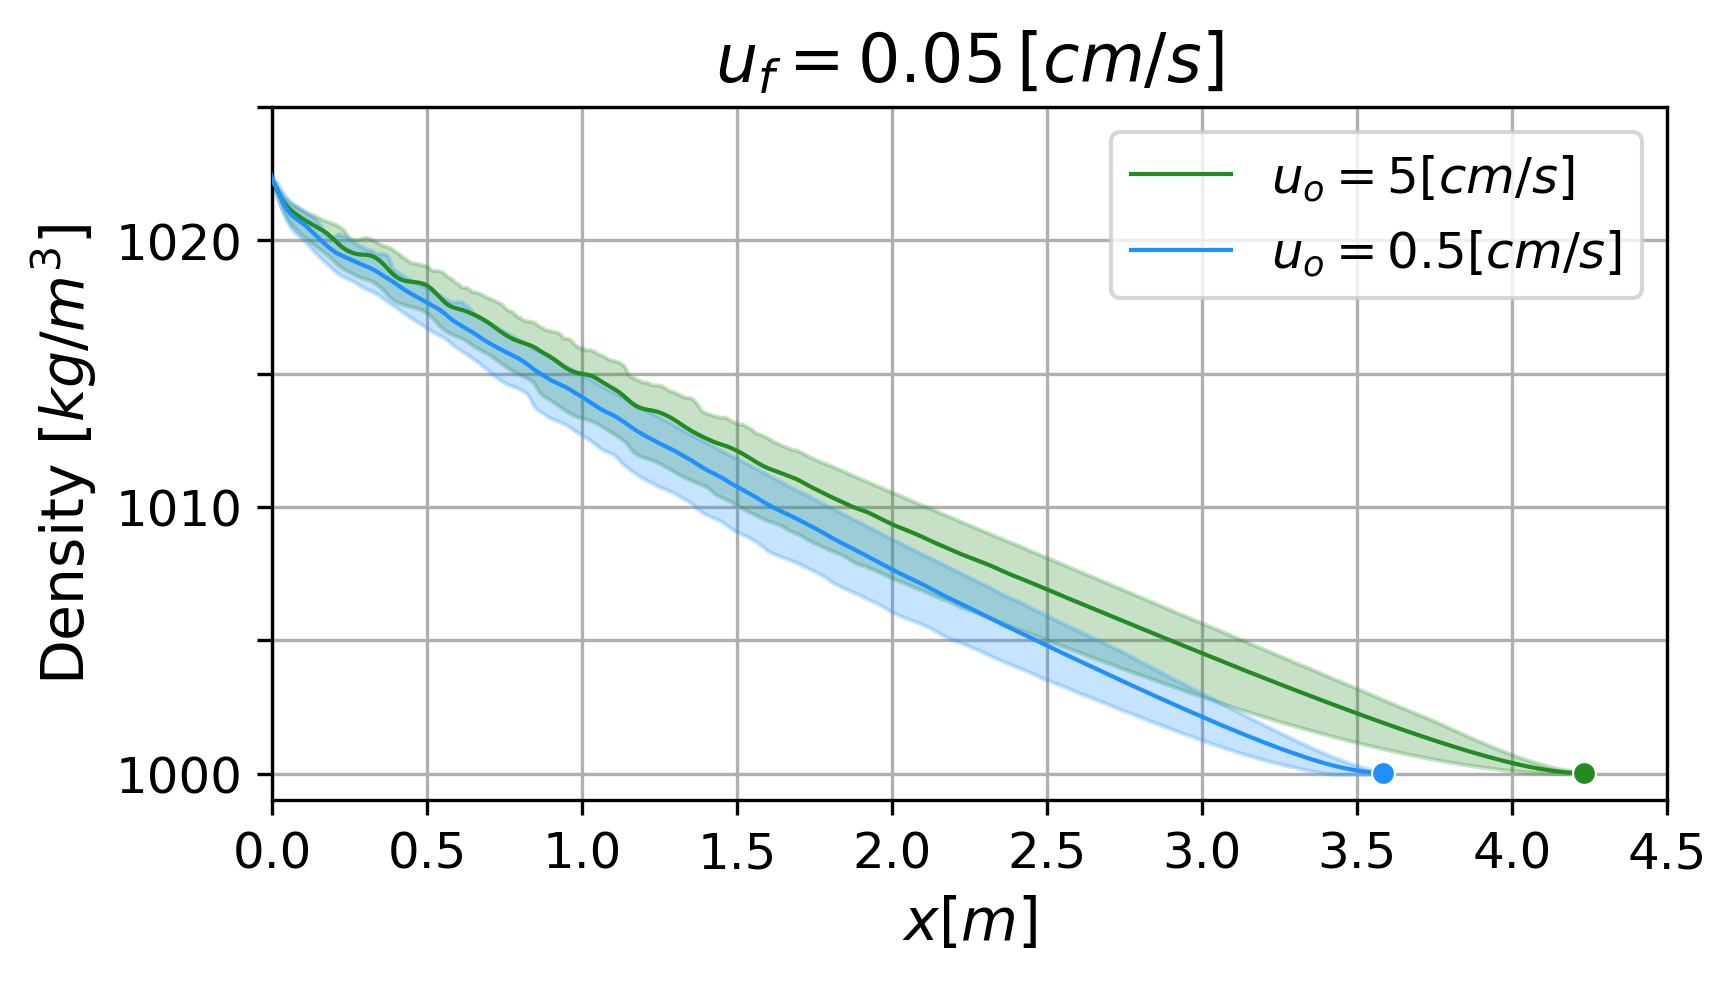

In [14]:
fig, ax = plt.subplots(1, figsize = (6,3), dpi = 300);

faster_uo, = ax.plot(F3cu2_o1_intru['x'], F3cu2_o1_intru['mean'], color = 'forestgreen', zorder = 3, linewidth = 1);
ax.fill_between(F3cu2_o1_intru['x'], F3cu2_o1_intru['plus'], F3cu2_o1_intru['minus'], alpha = 0.25, zorder = 2, color = 'forestgreen')
ax.scatter(F3cu2_o1_intru['x'].iloc[-1], F3cu2_o1_intru['mean'].iloc[-1], color = 'forestgreen', zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

norm_uo, = ax.plot(F3cu2_intru['x'], F3cu2_intru['mean'], color = cmap[1], zorder = 3, linewidth = 1);
ax.fill_between(F3cu2_intru['x'], F3cu2_intru['plus'], F3cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[1])
ax.scatter(F3cu2_intru['x'].iloc[-1], F3cu2_intru['mean'].iloc[-1], color = cmap[1], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

ax.set_xlim(0,4.5); ax.set_ylim(999,1020); ax.grid()
ax.legend([faster_uo, norm_uo], ['$u_o = 5 [cm/s]$', '$u_o = 0.5 [cm/s]$']);

ax.set_yticks([1000,1005,1010,1015,1020,1025]); ax.set_yticklabels([1000,'',1010,'',1020,'']); 
ax.set_ylabel('Density $[kg/m^3]$');
ax.set_xlabel('$x [m]$');
ax.set_title('$u_f = 0.05 \, [cm/s]$');

plt.savefig('variable_Uo.png', dpi = 500);

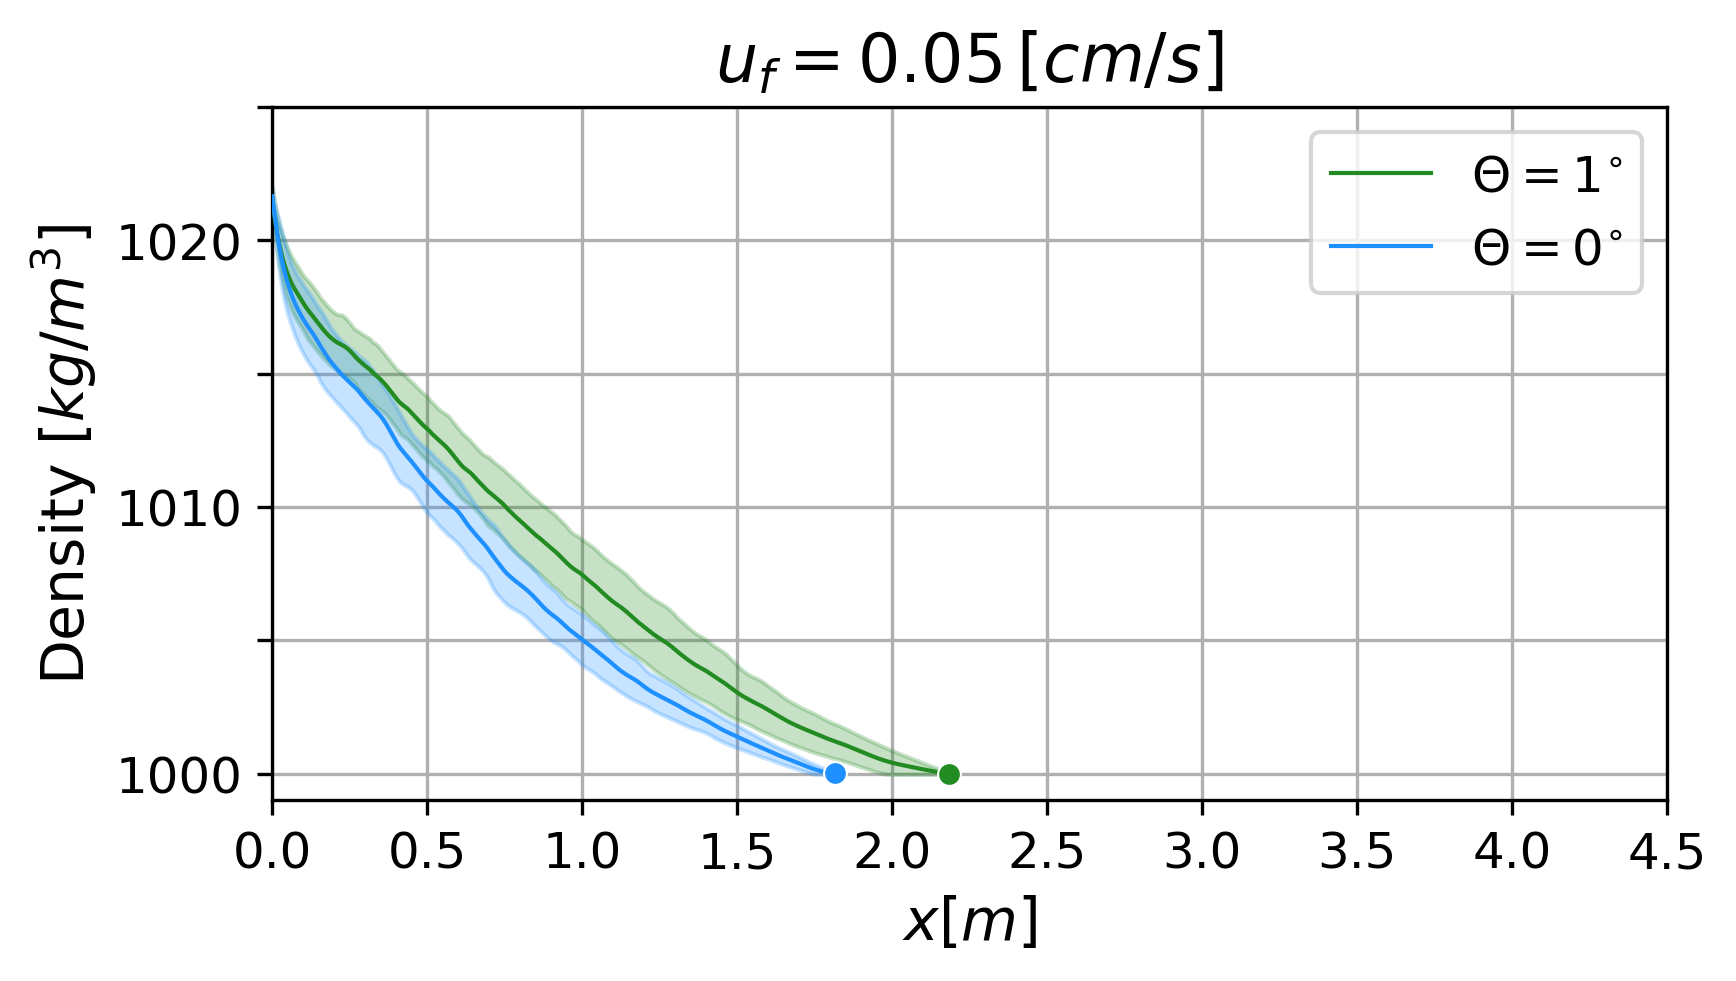

In [21]:
fig, ax = plt.subplots(1, figsize = (6,3), dpi = 300);

oneDeg, = ax.plot(F4cu2_1deg_intru['x'], F4cu2_1deg_intru['mean'], color = 'forestgreen', zorder = 3, linewidth = 1);
ax.fill_between(F4cu2_1deg_intru['x'], F4cu2_1deg_intru['plus'], F4cu2_1deg_intru['minus'], alpha = 0.25, zorder = 2, color = 'forestgreen')
ax.scatter(F4cu2_1deg_intru['x'].iloc[-1], F4cu2_1deg_intru['mean'].iloc[-1], color = 'forestgreen', zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

flat, = ax.plot(F4cu2_intru['x'], F4cu2_intru['mean'], color = cmap[1], zorder = 3, linewidth = 1);
ax.fill_between(F4cu2_intru['x'], F4cu2_intru['plus'], F4cu2_intru['minus'], alpha = 0.25, zorder = 2, color = cmap[1])
ax.scatter(F4cu2_intru['x'].iloc[-1], F4cu2_intru['mean'].iloc[-1], color = cmap[1], zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

ax.set_xlim(0,4.5); ax.set_ylim(999,1020); ax.grid()
ax.legend([oneDeg, flat], ['$\Theta = 1^{\circ}$', '$\Theta = 0^{\circ}$']);

ax.set_yticks([1000,1005,1010,1015,1020,1025]); ax.set_yticklabels([1000,'',1010,'',1020,'']); 
ax.set_ylabel('Density $[kg/m^3]$');
ax.set_xlabel('$x [m]$');
ax.set_title('$u_f = 0.05 \, [cm/s]$');

plt.savefig('1deg_intru.png', dpi = 500);

### Appendix Figures

Melt scenarios for the slanted and taller subglacial environment cases

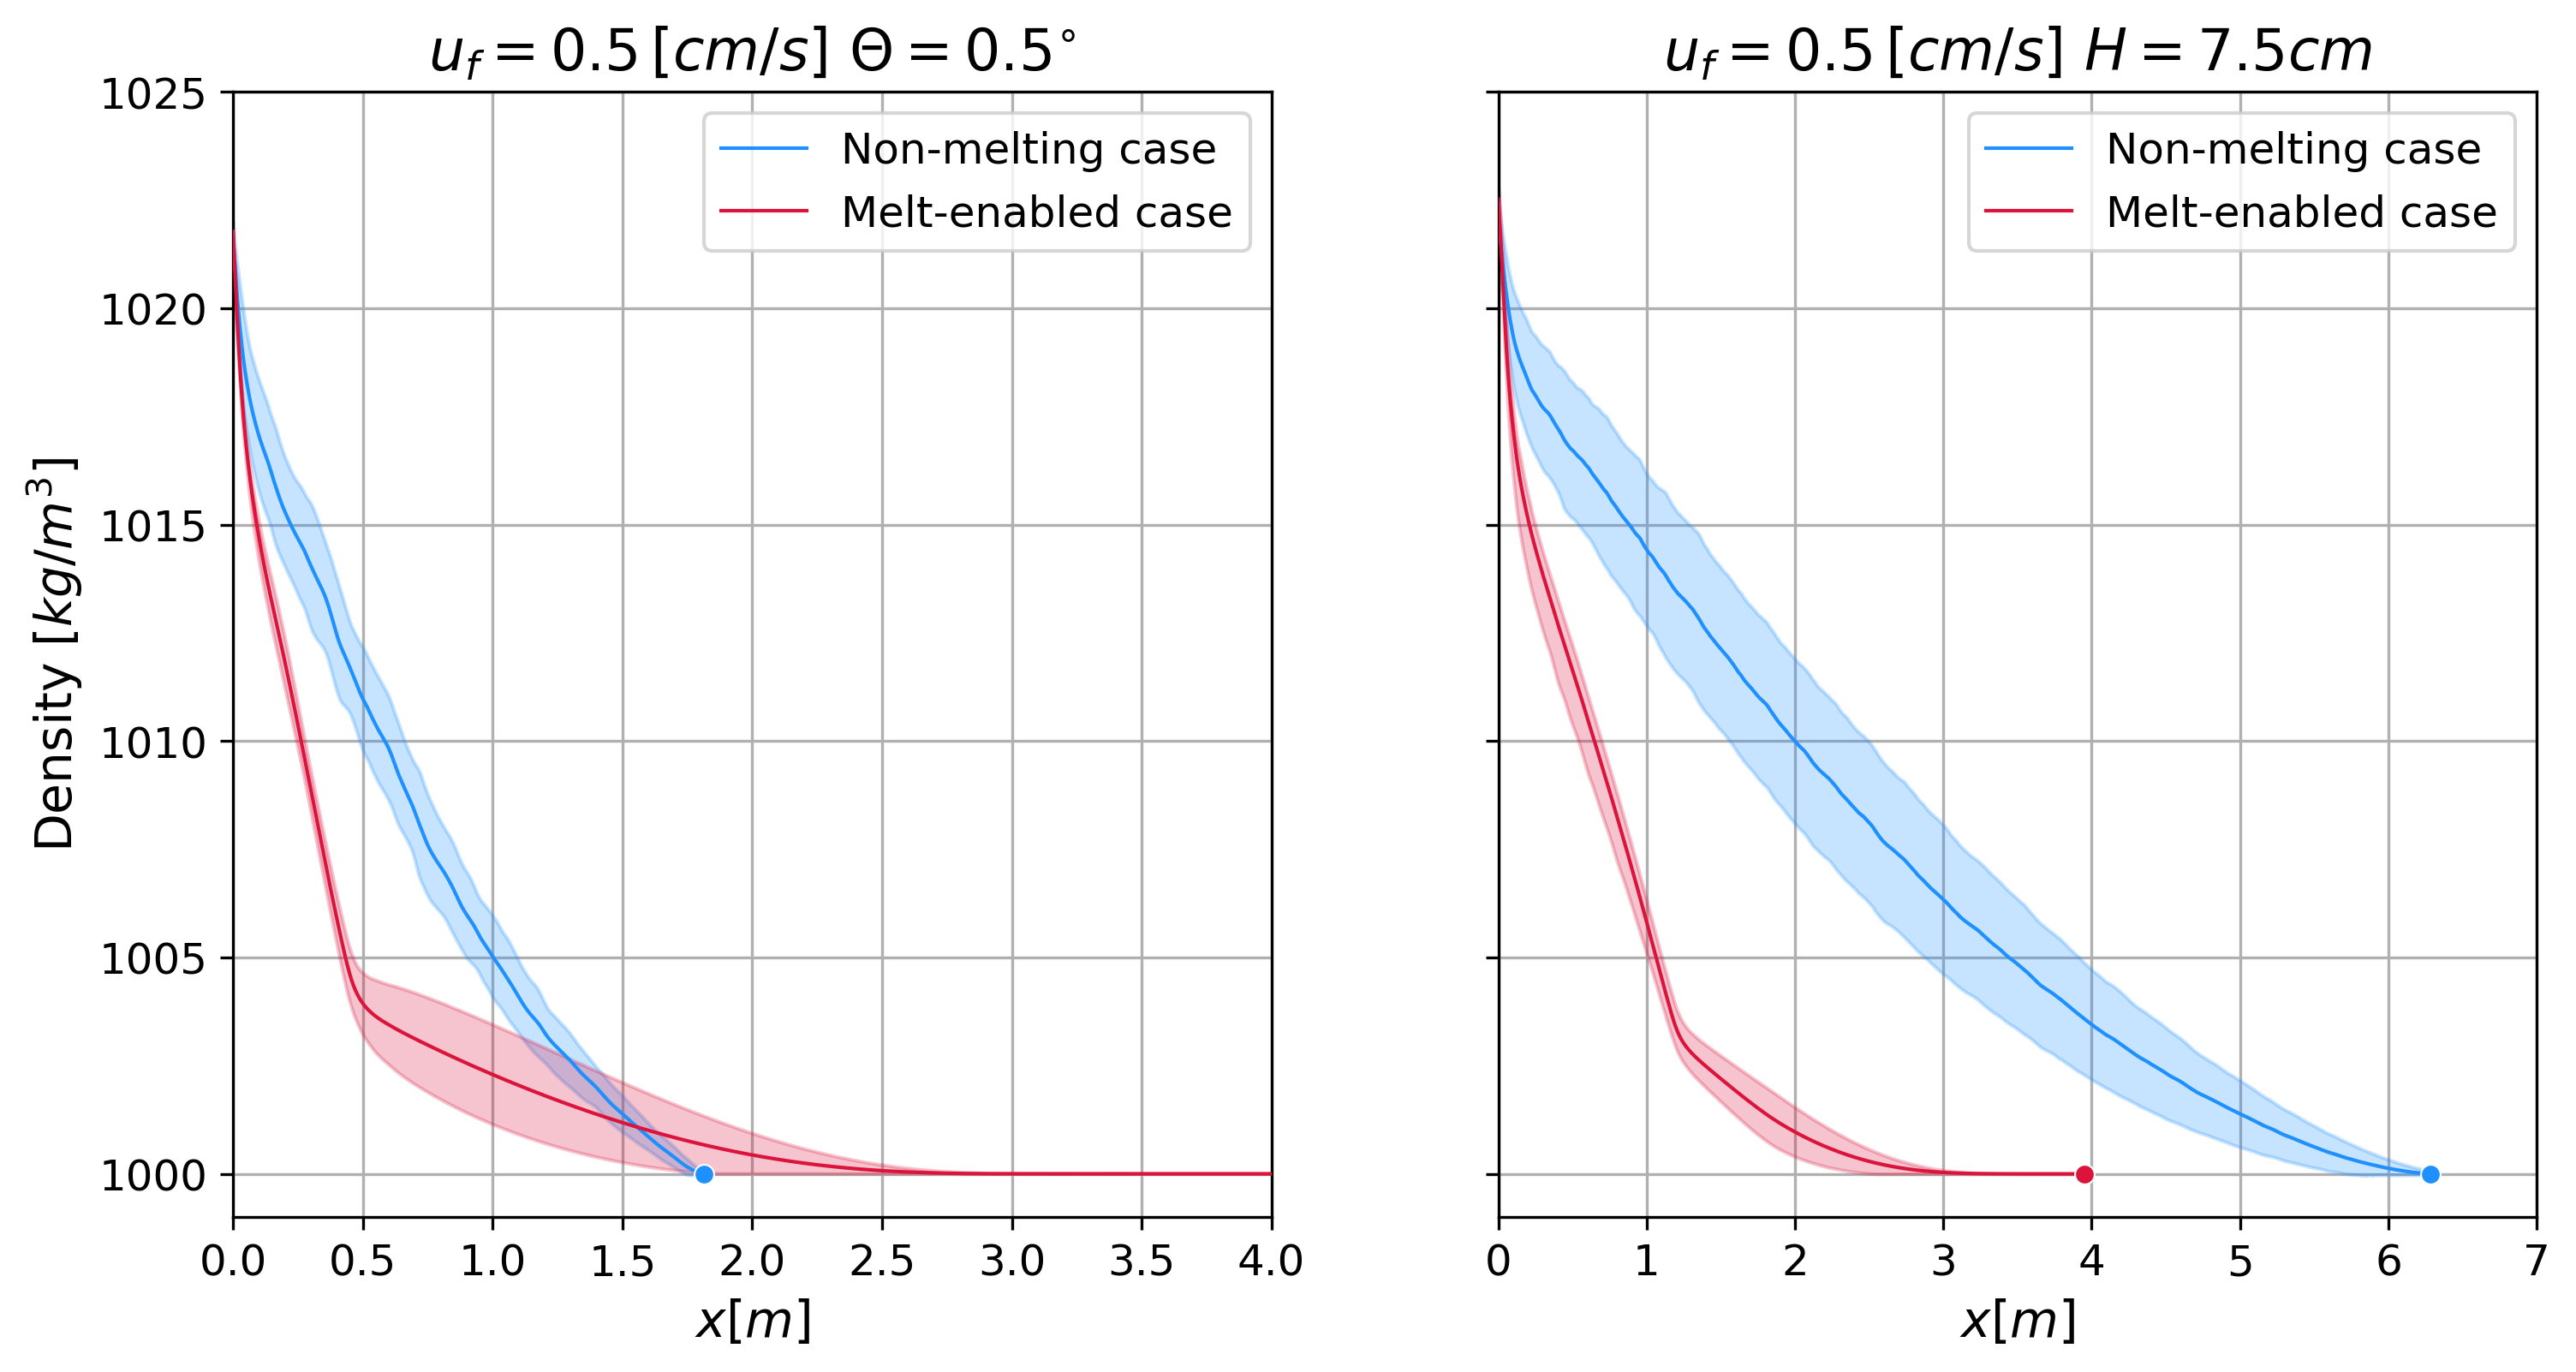

In [15]:
fig, ax = plt.subplots(1,2, figsize = (10,5), dpi = 300);

non_melt, = ax[0].plot(F4cu2_intru['x'], F4cu2_intru['mean'], color = 'dodgerblue', zorder = 3, linewidth = 1);
ax[0].fill_between(F4cu2_intru['x'], F4cu2_intru['plus'], F4cu2_intru['minus'], alpha = 0.25, zorder = 2, color = 'dodgerblue')
ax[0].scatter(F4cu2_intru['x'].iloc[-1], F4cu2_intru['mean'].iloc[-1], color = 'dodgerblue', zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

melt, = ax[0].plot(F4cu2_intru_bf['x'], F4cu2_intru_bf['mean'], color = 'crimson', zorder = 3, linewidth = 1);
ax[0].fill_between(F4cu2_intru_bf['x'], F4cu2_intru_bf['plus'], F4cu2_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'crimson')
ax[0].scatter(F4cu2_intru_bf['x'].iloc[-1], F4cu2_intru_bf['mean'].iloc[-1], color = 'crimson', zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

ax[0].set_xlim(0,4); ax[0].set_ylim(999,1020); ax[0].grid()
ax[0].legend([non_melt, melt], ['Non-melting case', 'Melt-enabled case']);


non_melt, = ax[1].plot(F5cu2_intru['x'], F5cu2_intru['mean'], color = 'dodgerblue', zorder = 3, linewidth = 1);
ax[1].fill_between(F5cu2_intru['x'], F5cu2_intru['plus'], F5cu2_intru['minus'], alpha = 0.25, zorder = 2, color = 'dodgerblue')
ax[1].scatter(F5cu2_intru['x'].iloc[-1], F5cu2_intru['mean'].iloc[-1], color = 'dodgerblue', zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

melt, = ax[1].plot(F5cu2_intru_bf['x'], F5cu2_intru_bf['mean'], color = 'crimson', zorder = 3, linewidth = 1);
ax[1].fill_between(F5cu2_intru_bf['x'], F5cu2_intru_bf['plus'], F5cu2_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'crimson')
ax[1].scatter(F5cu2_intru_bf['x'].iloc[-1], F5cu2_intru_bf['mean'].iloc[-1], color = 'crimson', zorder = 4, s = 30,edgecolor='white',linewidth = 0.5);

ax[1].set_xlim(0,7); ax[1].set_ylim(999,1020); ax[1].grid()
ax[1].legend([non_melt, melt], ['Non-melting case', 'Melt-enabled case']);

plt.tight_layout();

ax[0].set_yticks([1000,1005,1010,1015,1020,1025]); ax[1].set_yticks([1000,1005,1010,1015,1020,1025]); 
ax[0].set_yticklabels([1000,1005,1010,1015,1020,1025]); ax[1].set_yticklabels(['','','','','','']);
ax[0].set_ylabel('Density $[kg/m^3]$');
ax[0].set_xlabel('$x [m]$'); ax[1].set_xlabel('$x [m]$');
ax[0].set_title('$u_f = 0.5 \, [cm/s] \, \, \Theta = 0.5^{\circ}$');
ax[1].set_title('$u_f = 0.5 \, [cm/s] \,\, H = 7.5 cm$');

plt.savefig('f4_f5_melt.png', dpi = 500);

### Appendix Figures - Steady State vs Transient Solutions

First we read in all the steady state files, for this you will need the steady_state folder. We then get the intrusion criterion for density, temperature, and salinity for each case and then plot all of them together

In [9]:
F1cu1_ssPre_mid = pd.read_csv('steadyState/f1cu1_ssPre_lre_middle')
F1cu2_ssPre_mid = pd.read_csv('steadyState/f1cu2_ssPre_lre_middle')
F1cu3_ssPre_mid = pd.read_csv('steadyState/f1cu3_ssPre_lre_middle')

F1cu1_ssPost_mid = pd.read_csv('steadyState/f1cu1_ssPost_lre_middle')
F1cu2_ssPost_mid = pd.read_csv('steadyState/f1cu2_ssPost_lre_middle')
F1cu3_ssPost_mid = pd.read_csv('steadyState/f1cu3_ssPost_lre_middle')

############
F2cu1_ssPre_mid = pd.read_csv('steadyState/f2cu1_ssPre_middle')
F2cu2_ssPre_mid = pd.read_csv('steadyState/f2cu2_ssPre_middle')
F2cu3_ssPre_mid = pd.read_csv('steadyState/f2cu3_ssPre_middle')
F2cu2_bf_ssPre_mid = pd.read_csv('steadyState/f2cu2_bf_ssPre_middle')
F2_lam_ssPre_mid = pd.read_csv('steadyState/f2_lam_ssPre_middle')

F2cu1_ssPost_mid = pd.read_csv('steadyState/f2cu1_ssPost_middle')
F2cu2_ssPost_mid = pd.read_csv('steadyState/f2cu2_ssPost_middle')
F2cu3_ssPost_mid = pd.read_csv('steadyState/f2cu3_ssPost_middle')
F2cu2_bf_ssPost_mid = pd.read_csv('steadyState/f2cu2_bf_ssPost_middle')
F2_lam_ssPost_mid = pd.read_csv('steadyState/f2_lam_ssPost_middle')
############
F3cu1_ssPre_mid = pd.read_csv('steadyState/f3cu1_ssPre_middle')
F3cu2_ssPre_mid = pd.read_csv('steadyState/f3cu2_ssPre_middle')
F3cu3_ssPre_mid = pd.read_csv('steadyState/f3cu3_ssPre_middle')
F3cu2_o1_ssPre_mid = pd.read_csv('steadyState/f3cu2_o1_ssPre_middle')

F3cu1_ssPost_mid = pd.read_csv('steadyState/f3cu1_ssPost_middle')
F3cu2_ssPost_mid = pd.read_csv('steadyState/f3cu2_ssPost_middle')
F3cu3_ssPost_mid = pd.read_csv('steadyState/f3cu3_ssPost_middle')
F3cu2_o1_ssPost_mid = pd.read_csv('steadyState/f3cu2_o1_ssPost_middle')

###########
F4cu2_ssPre_mid = pd.read_csv('steadyState/f4cu2_ssPre_middle')
F4cu2_bf_ssPre_mid = pd.read_csv('steadyState/f4cu2_bf_ssPre_middle')

F4cu2_ssPost_mid = pd.read_csv('steadyState/f4cu2_ssPost_middle')
F4cu2_bf_ssPost_mid = pd.read_csv('steadyState/f4cu2_bf_ssPost_middle')
###########
F5cu2_ssPre_mid = pd.read_csv('steadyState/f5cu2_ssPre_middle')
F5cu2_bf_ssPre_mid = pd.read_csv('steadyState/f5cu2_bf_ssPre_middle')

F5cu2_ssPost_mid = pd.read_csv('steadyState/f5cu2_ssPost_middle')
F5cu2_bf_ssPost_mid = pd.read_csv('steadyState/f5cu2_bf_ssPost_middle')


In [10]:
f1cu1_pre = intrusionLen_ss(F1cu1_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f1cu2_pre = intrusionLen_ss(F1cu2_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f1cu3_pre = intrusionLen_ss(F1cu3_ssPre_mid.sort_values(by='    x-coordinate'), 1000)

f1cu1_post = intrusionLen_ss(F1cu1_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f1cu2_post = intrusionLen_ss(F1cu2_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f1cu3_post = intrusionLen_ss(F1cu3_ssPost_mid.sort_values(by='    x-coordinate'), 1000)

########
f2cu1_pre = intrusionLen_ss(F2cu1_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f2cu2_pre = intrusionLen_ss(F2cu2_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f2cu3_pre = intrusionLen_ss(F2cu3_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f2cu2_bf_pre = intrusionLen_ss(F2cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f2_lam_pre = intrusionLen_ss(F2_lam_ssPre_mid.sort_values(by='    x-coordinate'), 1000)

f2cu1_post = intrusionLen_ss(F2cu1_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f2cu2_post = intrusionLen_ss(F2cu2_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f2cu3_post = intrusionLen_ss(F2cu3_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f2cu2_bf_post = intrusionLen_ss(F2cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f2_lam_post = intrusionLen_ss(F2_lam_ssPost_mid.sort_values(by='    x-coordinate'), 1000)

# ########
f3cu1_pre = intrusionLen_ss(F3cu1_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f3cu2_pre = intrusionLen_ss(F3cu2_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f3cu3_pre = intrusionLen_ss(F3cu3_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f3cu2_o1_pre = intrusionLen_ss(F3cu2_o1_ssPre_mid.sort_values(by='    x-coordinate'), 1000)

f3cu1_post = intrusionLen_ss(F3cu1_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f3cu2_post = intrusionLen_ss(F3cu2_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f3cu3_post = intrusionLen_ss(F3cu3_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f3cu2_o1_post = intrusionLen_ss(F3cu2_o1_ssPost_mid.sort_values(by='    x-coordinate'), 1000)

########
f4cu2_pre = intrusionLen_ss(F4cu2_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f4cu2_bf_pre = intrusionLen_ss(F4cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 1000)

f4cu2_post = intrusionLen_ss(F4cu2_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f4cu2_bf_post = intrusionLen_ss(F4cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 1000)

########
f5cu2_pre = intrusionLen_ss(F5cu2_ssPre_mid.sort_values(by='    x-coordinate'), 1000)
f5cu2_bf_pre = intrusionLen_ss(F5cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 1000)

f5cu2_post = intrusionLen_ss(F5cu2_ssPost_mid.sort_values(by='    x-coordinate'), 1000)
f5cu2_bf_post = intrusionLen_ss(F5cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 1000)


In [11]:
f1cu1_temp_pre = intrusionLen_temp_ss(F1cu1_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f1cu2_temp_pre = intrusionLen_temp_ss(F1cu2_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f1cu3_temp_pre = intrusionLen_temp_ss(F1cu3_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)

f1cu1_temp_post = intrusionLen_temp_ss(F1cu1_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f1cu2_temp_post = intrusionLen_temp_ss(F1cu2_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f1cu3_temp_post = intrusionLen_temp_ss(F1cu3_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)

########
f2cu1_temp_pre = intrusionLen_temp_ss(F2cu1_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f2cu2_temp_pre = intrusionLen_temp_ss(F2cu2_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f2cu3_temp_pre = intrusionLen_temp_ss(F2cu3_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f2cu2_bf_temp_pre = intrusionLen_temp_ss(F2cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f2_lam_temp_pre = intrusionLen_temp_ss(F2_lam_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)

f2cu1_temp_post = intrusionLen_temp_ss(F2cu1_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f2cu2_temp_post = intrusionLen_temp_ss(F2cu2_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f2cu3_temp_post = intrusionLen_temp_ss(F2cu3_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f2cu2_bf_temp_post = intrusionLen_temp_ss(F2cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f2_lam_temp_post = intrusionLen_temp_ss(F2_lam_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)

# ########
f3cu1_temp_pre = intrusionLen_temp_ss(F3cu1_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f3cu2_temp_pre = intrusionLen_temp_ss(F3cu2_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f3cu3_temp_pre = intrusionLen_temp_ss(F3cu3_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f3cu2_o1_temp_pre = intrusionLen_temp_ss(F3cu2_o1_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)

f3cu1_temp_post = intrusionLen_temp_ss(F3cu1_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f3cu2_temp_post = intrusionLen_temp_ss(F3cu2_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f3cu3_temp_post = intrusionLen_temp_ss(F3cu3_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f3cu2_o1_temp_post = intrusionLen_temp_ss(F3cu2_o1_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)

########

f4cu2_temp_pre = intrusionLen_temp_ss(F4cu2_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f4cu2_bf_temp_pre = intrusionLen_temp_ss(F4cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)

f4cu2_temp_post = intrusionLen_temp_ss(F4cu2_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f4cu2_bf_temp_post = intrusionLen_temp_ss(F4cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)

########

f5cu2_temp_pre = intrusionLen_temp_ss(F5cu2_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)
f5cu2_bf_temp_pre = intrusionLen_temp_ss(F5cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 273.15)

f5cu2_temp_post = intrusionLen_temp_ss(F5cu2_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)
f5cu2_bf_temp_post = intrusionLen_temp_ss(F5cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 273.15)


In [12]:
f1cu1_salt_pre = intrusionLen_salt_ss(F1cu1_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f1cu2_salt_pre = intrusionLen_salt_ss(F1cu2_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f1cu3_salt_pre = intrusionLen_salt_ss(F1cu3_ssPre_mid.sort_values(by='    x-coordinate'), 0)

f1cu1_salt_post = intrusionLen_salt_ss(F1cu1_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f1cu2_salt_post = intrusionLen_salt_ss(F1cu2_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f1cu3_salt_post = intrusionLen_salt_ss(F1cu3_ssPost_mid.sort_values(by='    x-coordinate'), 0)

########
f2cu1_salt_pre = intrusionLen_salt_ss(F2cu1_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f2cu2_salt_pre = intrusionLen_salt_ss(F2cu2_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f2cu3_salt_pre = intrusionLen_salt_ss(F2cu3_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f2cu2_bf_salt_pre = intrusionLen_salt_ss(F2cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f2_lam_salt_pre = intrusionLen_salt_ss(F2_lam_ssPre_mid.sort_values(by='    x-coordinate'), 0)

f2cu1_salt_post = intrusionLen_salt_ss(F2cu1_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f2cu2_salt_post = intrusionLen_salt_ss(F2cu2_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f2cu3_salt_post = intrusionLen_salt_ss(F2cu3_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f2cu2_bf_salt_post = intrusionLen_salt_ss(F2cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f2_lam_salt_post = intrusionLen_salt_ss(F2_lam_ssPost_mid.sort_values(by='    x-coordinate'), 0)

# ########
f3cu1_salt_pre = intrusionLen_salt_ss(F3cu1_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f3cu2_salt_pre = intrusionLen_salt_ss(F3cu2_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f3cu3_salt_pre = intrusionLen_salt_ss(F3cu3_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f3cu2_o1_salt_pre = intrusionLen_salt_ss(F3cu2_o1_ssPre_mid.sort_values(by='    x-coordinate'), 0)

f3cu1_salt_post = intrusionLen_salt_ss(F3cu1_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f3cu2_salt_post = intrusionLen_salt_ss(F3cu2_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f3cu3_salt_post = intrusionLen_salt_ss(F3cu3_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f3cu2_o1_salt_post = intrusionLen_salt_ss(F3cu2_o1_ssPost_mid.sort_values(by='    x-coordinate'), 0)

########

f4cu2_salt_pre = intrusionLen_salt_ss(F4cu2_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f4cu2_bf_salt_pre = intrusionLen_salt_ss(F4cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 0)

f4cu2_salt_post = intrusionLen_salt_ss(F4cu2_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f4cu2_bf_salt_post = intrusionLen_salt_ss(F4cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 0)

########

f5cu2_salt_pre = intrusionLen_salt_ss(F5cu2_ssPre_mid.sort_values(by='    x-coordinate'), 0)
f5cu2_bf_salt_pre = intrusionLen_salt_ss(F5cu2_bf_ssPre_mid.sort_values(by='    x-coordinate'), 0)

f5cu2_salt_post = intrusionLen_salt_ss(F5cu2_ssPost_mid.sort_values(by='    x-coordinate'), 0)
f5cu2_bf_salt_post = intrusionLen_salt_ss(F5cu2_bf_ssPost_mid.sort_values(by='    x-coordinate'), 0)


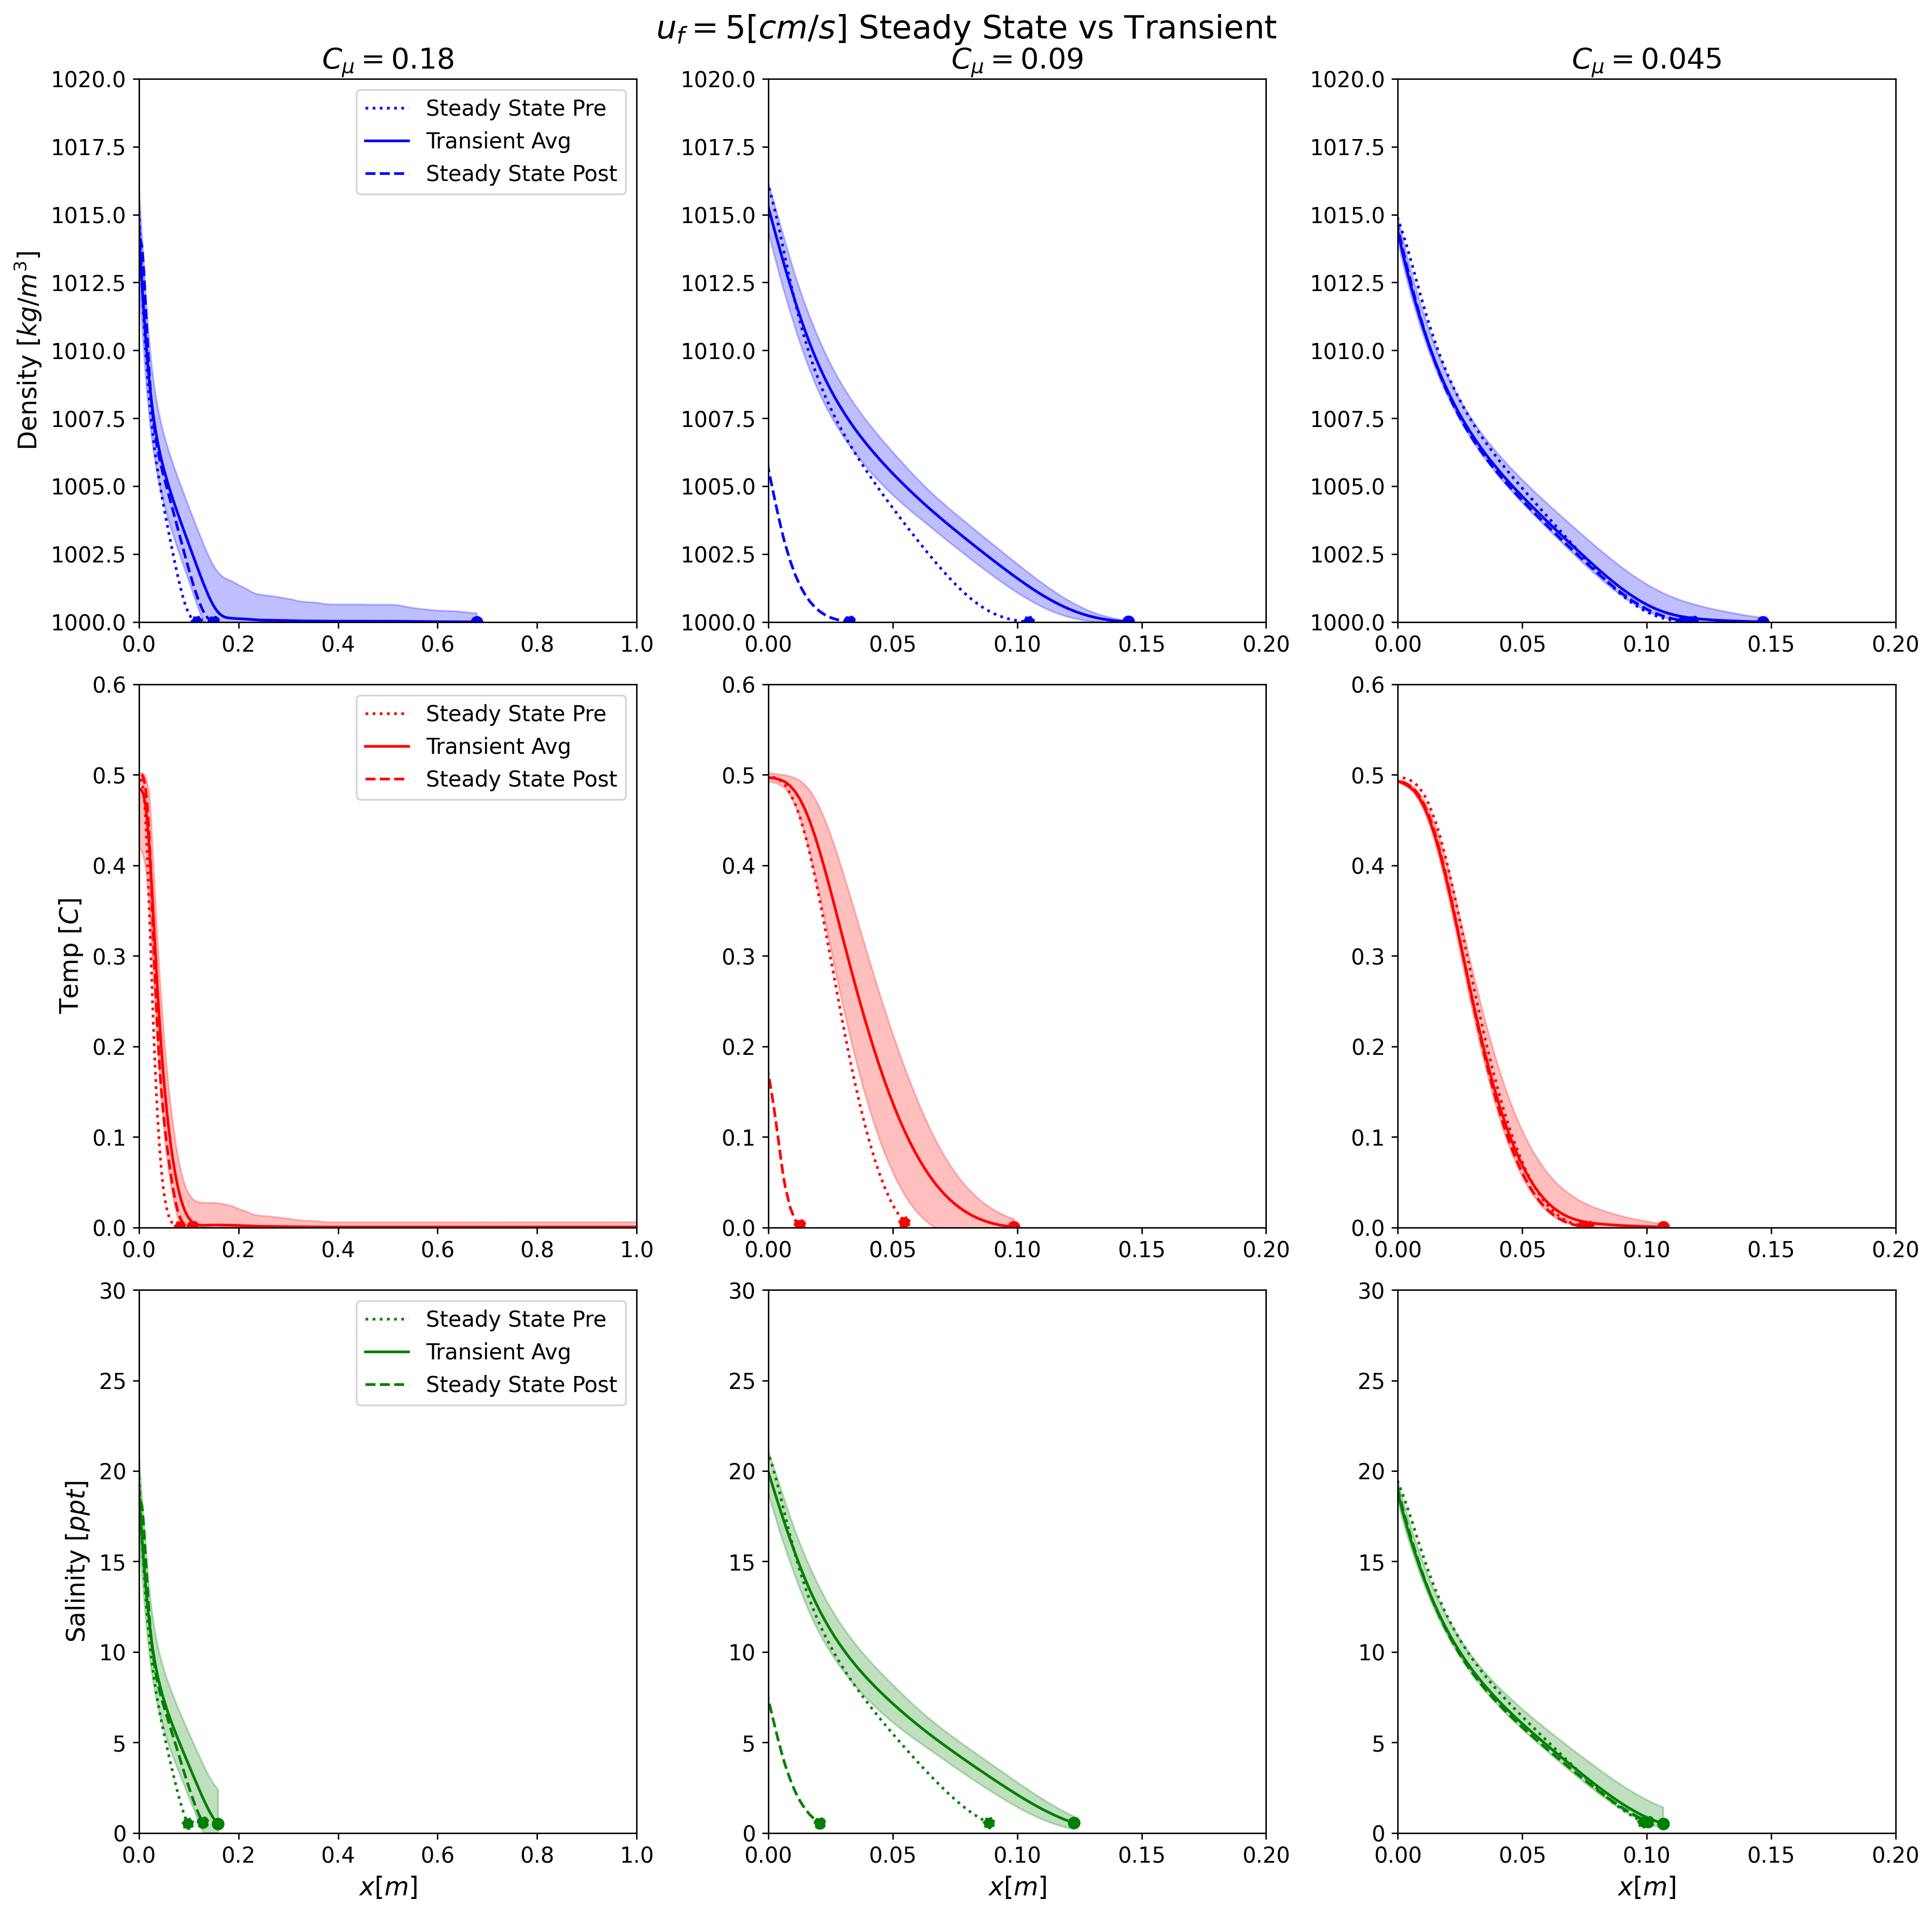

In [13]:
fig, ax = plt.subplots(3,3, figsize = (15,15), dpi = 250)

ax[0,0].plot(f1cu1_pre['x'], f1cu1_pre['dense'], color = 'blue', linestyle = ':')
ax[0,0].plot(F1cu1_intru['x'], F1cu1_intru['mean'], color = 'blue')
ax[0,0].plot(f1cu1_post['x'], f1cu1_post['dense'], color = 'blue', linestyle = '--')

ax[0,0].fill_between(F1cu1_intru['x'], F1cu1_intru['plus'], F1cu1_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,0].scatter(f1cu1_pre['x'].iloc[-1], f1cu1_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,0].scatter(F1cu1_intru['x'].iloc[-1], F1cu1_intru['mean'].iloc[-1], color = 'blue')
ax[0,0].scatter(f1cu1_post['x'].iloc[-1], f1cu1_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
##
ax[1,0].plot(f1cu1_temp_pre['x'], f1cu1_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,0].plot(F1cu1_temp_intru['x'], F1cu1_temp_intru['mean'], color = 'red')
ax[1,0].plot(f1cu1_temp_post['x'], f1cu1_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,0].fill_between(F1cu1_temp_intru['x'], F1cu1_temp_intru['plus'], F1cu1_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,0].scatter(f1cu1_temp_pre['x'].iloc[-1], f1cu1_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,0].scatter(F1cu1_temp_intru['x'].iloc[-1], F1cu1_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,0].scatter(f1cu1_temp_post['x'].iloc[-1], f1cu1_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
##
ax[2,0].plot(f1cu1_salt_pre['x'], f1cu1_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,0].plot(F1cu1_salt_intru['x'], F1cu1_salt_intru['mean'], color = 'green')
ax[2,0].plot(f1cu1_salt_post['x'], f1cu1_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,0].fill_between(F1cu1_salt_intru['x'], F1cu1_salt_intru['plus'], F1cu1_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,0].scatter(f1cu1_salt_pre['x'].iloc[-1], f1cu1_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,0].scatter(F1cu1_salt_intru['x'].iloc[-1], F1cu1_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,0].scatter(f1cu1_salt_post['x'].iloc[-1], f1cu1_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,1].plot(f1cu2_pre['x'], f1cu2_pre['dense'], color = 'blue', linestyle = ':')
ax[0,1].plot(F1cu2_intru['x'], F1cu2_intru['mean'], color = 'blue')
ax[0,1].plot(f1cu2_post['x'], f1cu2_post['dense'], color = 'blue', linestyle = '--')

ax[0,1].fill_between(F1cu2_intru['x'], F1cu2_intru['plus'], F1cu2_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,1].scatter(f1cu2_pre['x'].iloc[-1], f1cu2_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,1].scatter(F1cu2_intru['x'].iloc[-1], F1cu2_intru['mean'].iloc[-1], color = 'blue')
ax[0,1].scatter(f1cu2_post['x'].iloc[-1], f1cu2_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,1].plot(f1cu2_temp_pre['x'], f1cu2_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,1].plot(F1cu2_temp_intru['x'], F1cu2_temp_intru['mean'], color = 'red')
ax[1,1].plot(f1cu2_temp_post['x'], f1cu2_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,1].fill_between(F1cu2_temp_intru['x'], F1cu2_temp_intru['plus'], F1cu2_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,1].scatter(f1cu2_temp_pre['x'].iloc[-1], f1cu2_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,1].scatter(F1cu2_temp_intru['x'].iloc[-1], F1cu2_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,1].scatter(f1cu2_temp_post['x'].iloc[-1], f1cu2_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,1].plot(f1cu2_salt_pre['x'], f1cu2_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,1].plot(F1cu2_salt_intru['x'], F1cu2_salt_intru['mean'], color = 'green')
ax[2,1].plot(f1cu2_salt_post['x'], f1cu2_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,1].fill_between(F1cu2_salt_intru['x'], F1cu2_salt_intru['plus'], F1cu2_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,1].scatter(f1cu2_salt_pre['x'].iloc[-1], f1cu2_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,1].scatter(F1cu2_salt_intru['x'].iloc[-1], F1cu2_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,1].scatter(f1cu2_salt_post['x'].iloc[-1], f1cu2_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,2].plot(f1cu3_pre['x'], f1cu3_pre['dense'], color = 'blue', linestyle = ':')
ax[0,2].plot(F1cu3_intru['x'], F1cu3_intru['mean'], color = 'blue')
ax[0,2].plot(f1cu3_post['x'], f1cu3_post['dense'], color = 'blue', linestyle = '--')

ax[0,2].fill_between(F1cu3_intru['x'], F1cu3_intru['plus'], F1cu3_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,2].scatter(f1cu3_pre['x'].iloc[-1], f1cu3_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,2].scatter(F1cu3_intru['x'].iloc[-1], F1cu3_intru['mean'].iloc[-1], color = 'blue')
ax[0,2].scatter(f1cu3_post['x'].iloc[-1], f1cu3_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,2].plot(f1cu3_temp_pre['x'], f1cu3_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,2].plot(F1cu3_temp_intru['x'], F1cu3_temp_intru['mean'], color = 'red')
ax[1,2].plot(f1cu3_temp_post['x'], f1cu3_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,2].fill_between(F1cu3_temp_intru['x'], F1cu3_temp_intru['plus'], F1cu3_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,2].scatter(f1cu3_temp_pre['x'].iloc[-1], f1cu3_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,2].scatter(F1cu3_temp_intru['x'].iloc[-1], F1cu3_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,2].scatter(f1cu3_temp_post['x'].iloc[-1], f1cu3_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,2].plot(f1cu3_salt_pre['x'], f1cu3_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,2].plot(F1cu3_salt_intru['x'], F1cu3_salt_intru['mean'], color = 'green')
ax[2,2].plot(f1cu3_salt_post['x'], f1cu3_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,2].fill_between(F1cu3_salt_intru['x'], F1cu3_salt_intru['plus'], F1cu3_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,2].scatter(f1cu3_salt_pre['x'].iloc[-1], f1cu3_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,2].scatter(F1cu3_salt_intru['x'].iloc[-1], F1cu3_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,2].scatter(f1cu3_salt_post['x'].iloc[-1], f1cu3_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####

#####
ax[0,0].set_xlim(0,1); ax[0,1].set_xlim(0,0.2); ax[0,2].set_xlim(0,0.2); 
ax[1,0].set_xlim(0,1); ax[1,1].set_xlim(0,0.2); ax[1,2].set_xlim(0,0.2); 
ax[2,0].set_xlim(0,1); ax[2,1].set_xlim(0,0.2); ax[2,2].set_xlim(0,0.2); 

ax[0,0].set_ylim(1000,1020); ax[0,1].set_ylim(1000,1020); ax[0,2].set_ylim(1000,1020);
ax[1,0].set_ylim(0,0.6); ax[1,1].set_ylim(0,0.6); ax[1,2].set_ylim(0,0.6); 
ax[2,0].set_ylim(0,30); ax[2,1].set_ylim(0,30); ax[2,2].set_ylim(0,30); 

ax[0,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[1,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[2,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])

ax[0,0].set_title('$C_\mu = 0.18$'); ax[0,1].set_title('$C_\mu = 0.09$'); ax[0,2].set_title('$C_\mu = 0.045$'); 
ax[0,0].set_ylabel('Density $[kg/m^3]$'); ax[1,0].set_ylabel('Temp $[C]$'); ax[2,0].set_ylabel('Salinity $[ppt]$');
ax[2,0].set_xlabel('$x [m]$'); ax[2,1].set_xlabel('$x [m]$'); ax[2,2].set_xlabel('$x [m]$'); 

fig.suptitle('$u_f = 5 [cm/s]$ Steady State vs Transient', fontsize = 18); plt.tight_layout();
plt.savefig('f1_ss_transAvg.png',facecolor = 'white',dpi = 500)

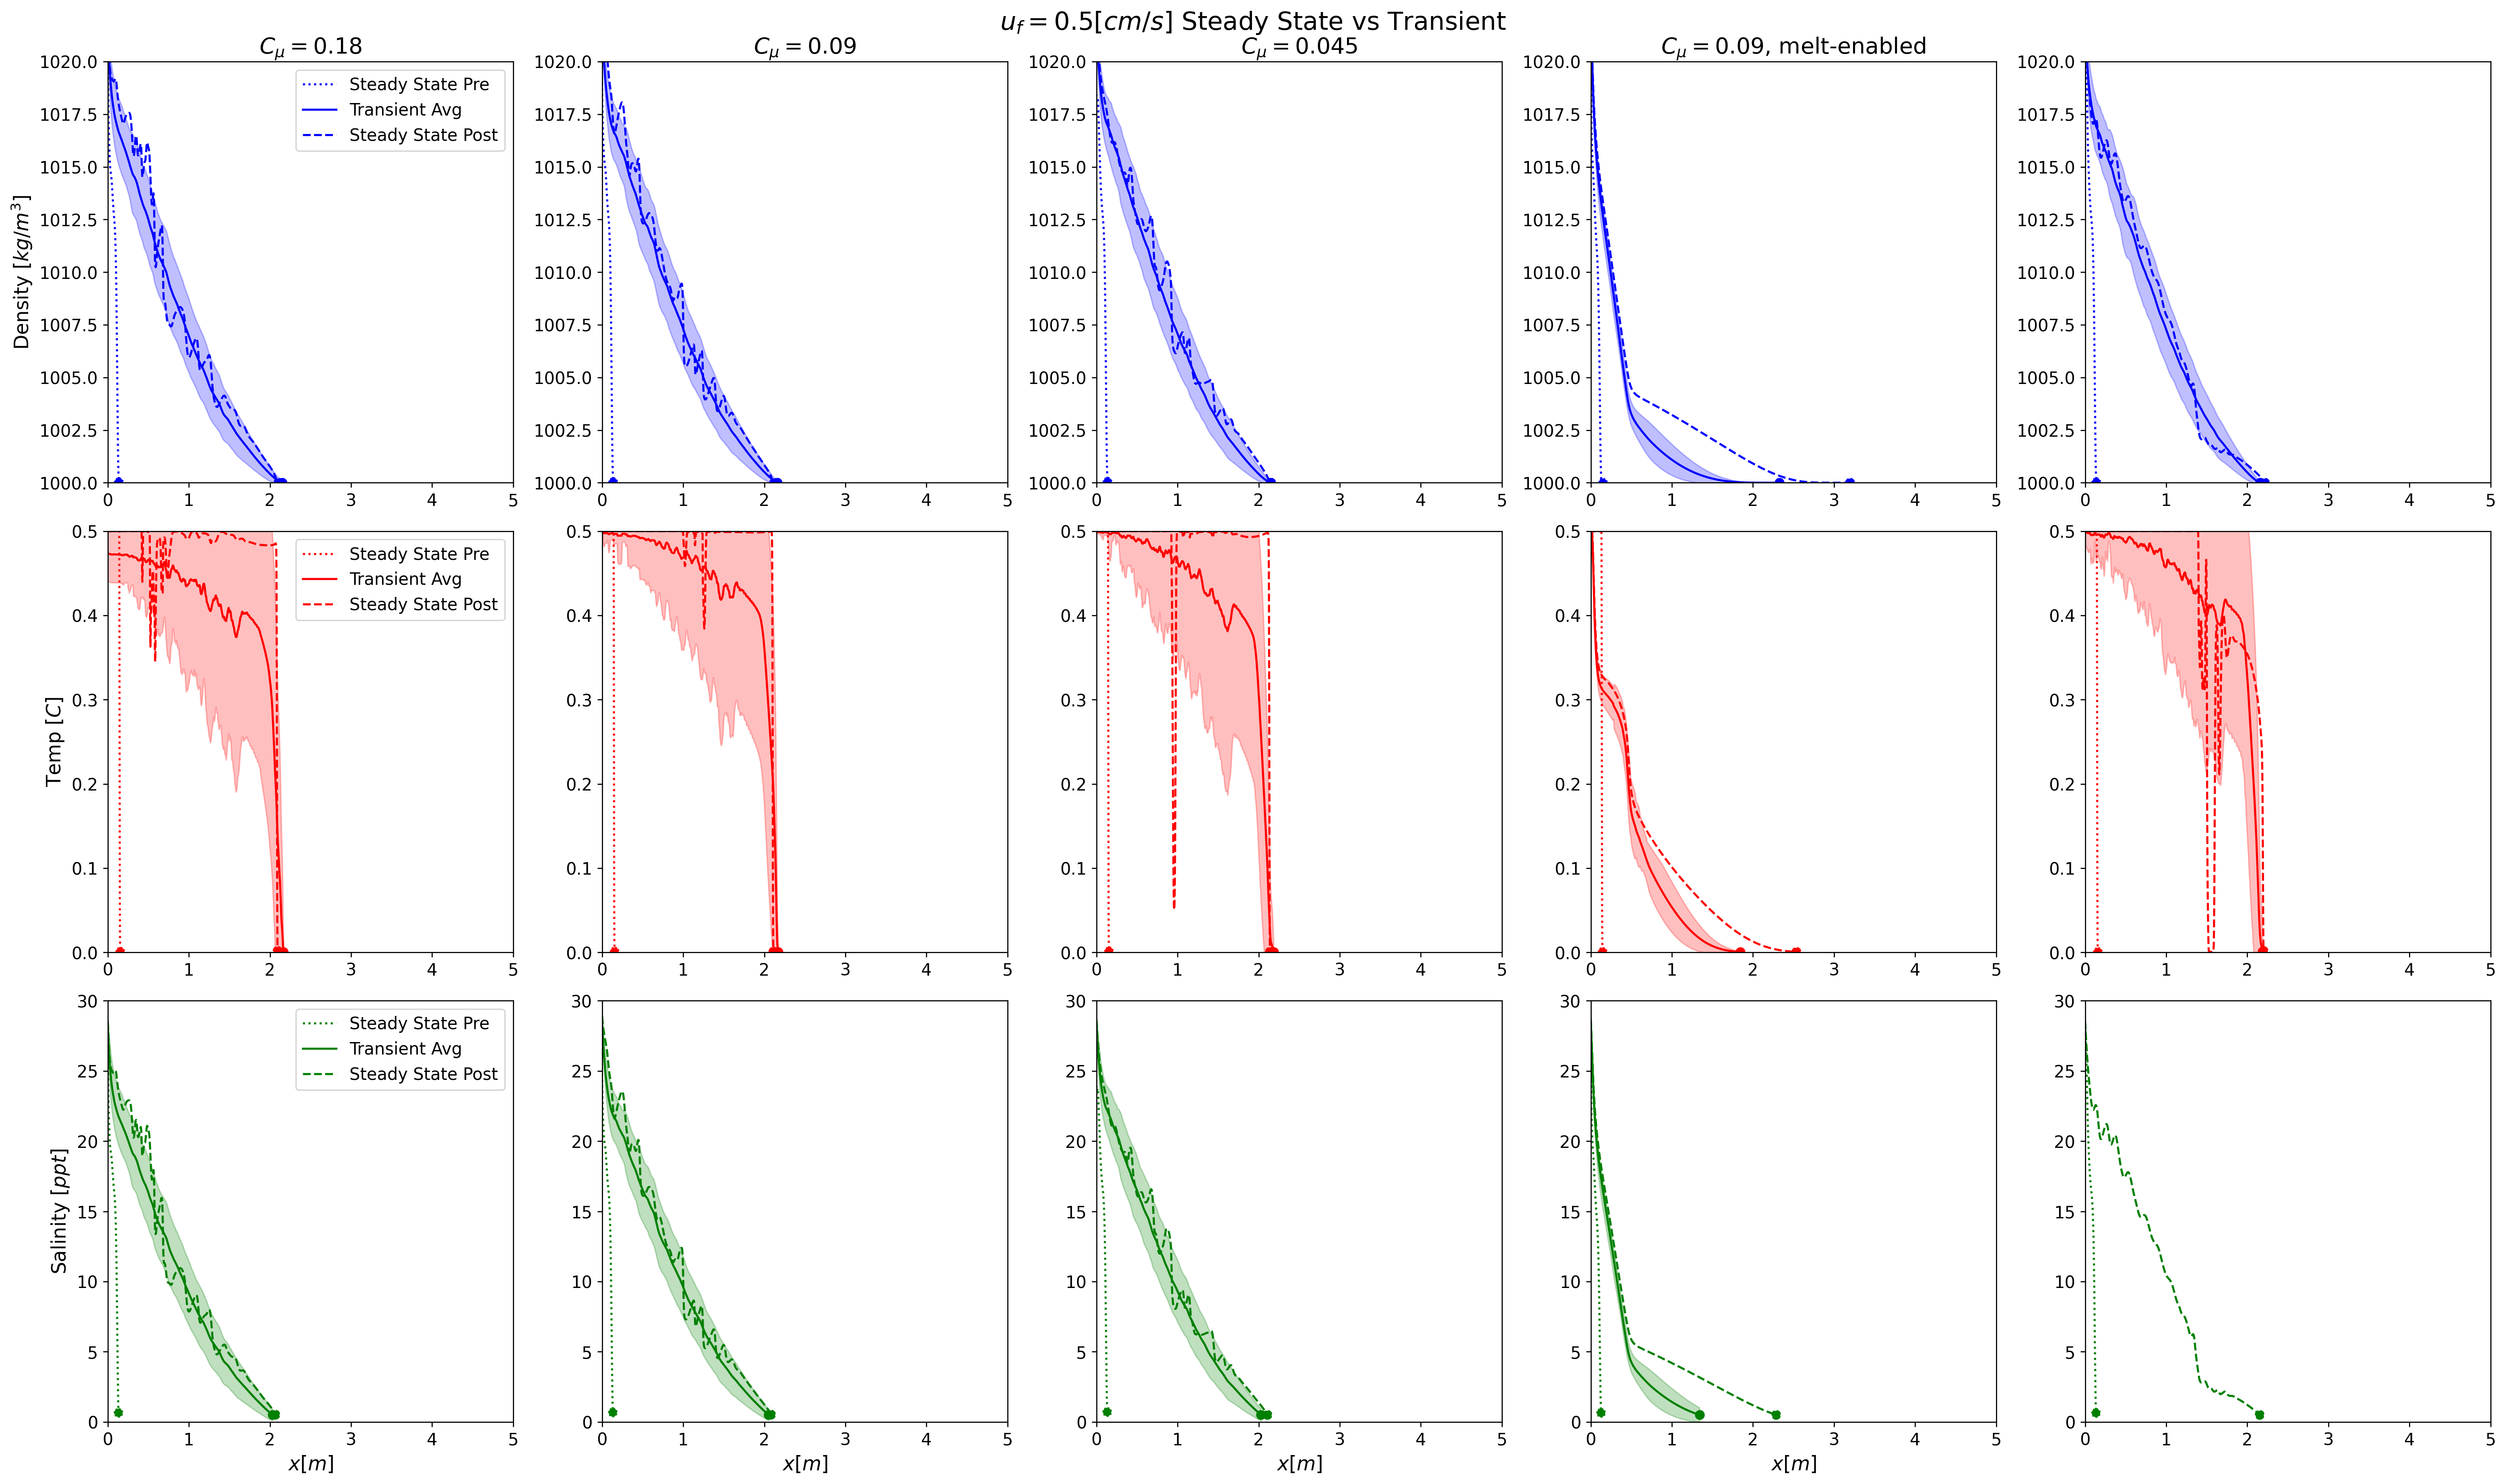

In [14]:
fig, ax = plt.subplots(3,5, figsize = (25,15), dpi = 250)

ax[0,0].plot(f2cu1_pre['x'], f2cu1_pre['dense'], color = 'blue', linestyle = ':')
ax[0,0].plot(F2cu1_intru['x'], F2cu1_intru['mean'], color = 'blue')
ax[0,0].plot(f2cu1_post['x'], f2cu1_post['dense'], color = 'blue', linestyle = '--')

ax[0,0].fill_between(F2cu1_intru['x'], F2cu1_intru['plus'], F2cu1_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,0].scatter(f2cu1_pre['x'].iloc[-1], f2cu1_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,0].scatter(F2cu1_intru['x'].iloc[-1], F2cu1_intru['mean'].iloc[-1], color = 'blue')
ax[0,0].scatter(f2cu1_post['x'].iloc[-1], f2cu1_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
##
ax[1,0].plot(f2cu1_temp_pre['x'], f2cu1_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,0].plot(F2cu1_temp_intru['x'], F2cu1_temp_intru['mean'], color = 'red')
ax[1,0].plot(f2cu1_temp_post['x'], f2cu1_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,0].fill_between(F2cu1_temp_intru['x'], F2cu1_temp_intru['plus'], F2cu1_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,0].scatter(f2cu1_temp_pre['x'].iloc[-1], f2cu1_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,0].scatter(F2cu1_temp_intru['x'].iloc[-1], F2cu1_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,0].scatter(f2cu1_temp_post['x'].iloc[-1], f2cu1_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
##
ax[2,0].plot(f2cu1_salt_pre['x'], f2cu1_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,0].plot(F2cu1_salt_intru['x'], F2cu1_salt_intru['mean'], color = 'green')
ax[2,0].plot(f2cu1_salt_post['x'], f2cu1_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,0].fill_between(F2cu1_salt_intru['x'], F2cu1_salt_intru['plus'], F2cu1_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,0].scatter(f2cu1_salt_pre['x'].iloc[-1], f2cu1_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,0].scatter(F2cu1_salt_intru['x'].iloc[-1], F2cu1_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,0].scatter(f2cu1_salt_post['x'].iloc[-1], f2cu1_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,1].plot(f2cu2_pre['x'], f2cu2_pre['dense'], color = 'blue', linestyle = ':')
ax[0,1].plot(F2cu2_intru['x'], F2cu2_intru['mean'], color = 'blue')
ax[0,1].plot(f2cu2_post['x'], f2cu2_post['dense'], color = 'blue', linestyle = '--')

ax[0,1].fill_between(F2cu2_intru['x'], F2cu2_intru['plus'], F2cu2_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,1].scatter(f2cu2_pre['x'].iloc[-1], f2cu2_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,1].scatter(F2cu2_intru['x'].iloc[-1], F2cu2_intru['mean'].iloc[-1], color = 'blue')
ax[0,1].scatter(f2cu2_post['x'].iloc[-1], f2cu2_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,1].plot(f2cu2_temp_pre['x'], f2cu2_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,1].plot(F2cu2_temp_intru['x'], F2cu2_temp_intru['mean'], color = 'red')
ax[1,1].plot(f2cu2_temp_post['x'], f2cu2_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,1].fill_between(F2cu2_temp_intru['x'], F2cu2_temp_intru['plus'], F2cu2_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,1].scatter(f2cu2_temp_pre['x'].iloc[-1], f2cu2_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,1].scatter(F2cu2_temp_intru['x'].iloc[-1], F2cu2_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,1].scatter(f2cu2_temp_post['x'].iloc[-1], f2cu2_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,1].plot(f2cu2_salt_pre['x'], f2cu2_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,1].plot(F2cu2_salt_intru['x'], F2cu2_salt_intru['mean'], color = 'green')
ax[2,1].plot(f2cu2_salt_post['x'], f2cu2_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,1].fill_between(F2cu2_salt_intru['x'], F2cu2_salt_intru['plus'], F2cu2_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,1].scatter(f2cu2_salt_pre['x'].iloc[-1], f2cu2_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,1].scatter(F2cu2_salt_intru['x'].iloc[-1], F2cu2_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,1].scatter(f2cu2_salt_post['x'].iloc[-1], f2cu2_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,2].plot(f2cu3_pre['x'], f2cu3_pre['dense'], color = 'blue', linestyle = ':')
ax[0,2].plot(F2cu3_intru['x'], F2cu3_intru['mean'], color = 'blue')
ax[0,2].plot(f2cu3_post['x'], f2cu3_post['dense'], color = 'blue', linestyle = '--')

ax[0,2].fill_between(F2cu3_intru['x'], F2cu3_intru['plus'], F2cu3_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,2].scatter(f2cu3_pre['x'].iloc[-1], f2cu3_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,2].scatter(F2cu3_intru['x'].iloc[-1], F2cu3_intru['mean'].iloc[-1], color = 'blue')
ax[0,2].scatter(f2cu3_post['x'].iloc[-1], f2cu3_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,2].plot(f2cu3_temp_pre['x'], f2cu3_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,2].plot(F2cu3_temp_intru['x'], F2cu3_temp_intru['mean'], color = 'red')
ax[1,2].plot(f2cu3_temp_post['x'], f2cu3_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,2].fill_between(F2cu3_temp_intru['x'], F2cu3_temp_intru['plus'], F2cu3_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,2].scatter(f2cu3_temp_pre['x'].iloc[-1], f2cu3_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,2].scatter(F2cu3_temp_intru['x'].iloc[-1], F2cu3_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,2].scatter(f2cu3_temp_post['x'].iloc[-1], f2cu3_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,2].plot(f2cu3_salt_pre['x'], f2cu3_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,2].plot(F2cu3_salt_intru['x'], F2cu3_salt_intru['mean'], color = 'green')
ax[2,2].plot(f2cu3_salt_post['x'], f2cu3_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,2].fill_between(F2cu3_salt_intru['x'], F2cu3_salt_intru['plus'], F2cu3_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,2].scatter(f2cu3_salt_pre['x'].iloc[-1], f2cu3_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,2].scatter(F2cu3_salt_intru['x'].iloc[-1], F2cu3_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,2].scatter(f2cu3_salt_post['x'].iloc[-1], f2cu3_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,3].plot(f2cu2_bf_pre['x'], f2cu2_bf_pre['dense'], color = 'blue', linestyle = ':')
ax[0,3].plot(F2cu2_intru_bf['x'], F2cu2_intru_bf['mean'], color = 'blue')
ax[0,3].plot(f2cu2_bf_post['x'], f2cu2_bf_post['dense'], color = 'blue', linestyle = '--')

ax[0,3].fill_between(F2cu2_intru_bf['x'], F2cu2_intru_bf['plus'], F2cu2_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,3].scatter(f2cu2_bf_pre['x'].iloc[-1], f2cu2_bf_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,3].scatter(F2cu2_intru_bf['x'].iloc[-1], F2cu2_intru_bf['mean'].iloc[-1], color = 'blue')
ax[0,3].scatter(f2cu2_bf_post['x'].iloc[-1], f2cu2_bf_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,3].plot(f2cu2_bf_temp_pre['x'], f2cu2_bf_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,3].plot(F2cu2_temp_intru_bf['x'], F2cu2_temp_intru_bf['mean'], color = 'red')
ax[1,3].plot(f2cu2_bf_temp_post['x'], f2cu2_bf_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,3].fill_between(F2cu2_temp_intru_bf['x'], F2cu2_temp_intru_bf['plus'], F2cu2_temp_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,3].scatter(f2cu2_bf_temp_pre['x'].iloc[-1], f2cu2_bf_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,3].scatter(F2cu2_temp_intru_bf['x'].iloc[-1], F2cu2_temp_intru_bf['mean'].iloc[-1], color = 'red')
ax[1,3].scatter(f2cu2_bf_temp_post['x'].iloc[-1], f2cu2_bf_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,3].plot(f2cu2_bf_salt_pre['x'], f2cu2_bf_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,3].plot(F2cu2_salt_intru_bf['x'], F2cu2_salt_intru_bf['mean'], color = 'green')
ax[2,3].plot(f2cu2_bf_salt_post['x'], f2cu2_bf_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,3].fill_between(F2cu2_salt_intru_bf['x'], F2cu2_salt_intru_bf['plus'], F2cu2_salt_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,3].scatter(f2cu2_bf_salt_pre['x'].iloc[-1], f2cu2_bf_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,3].scatter(F2cu2_salt_intru_bf['x'].iloc[-1], F2cu2_salt_intru_bf['mean'].iloc[-1], color = 'green')
ax[2,3].scatter(f2cu2_bf_salt_post['x'].iloc[-1], f2cu2_bf_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####

## Density
ax[0,4].plot(f2_lam_pre['x'], f2_lam_pre['dense'], color = 'blue', linestyle = ':')
ax[0,4].plot(F2_lam_intru['x'], F2_lam_intru['mean'], color = 'blue')
ax[0,4].plot(f2_lam_post['x'], f2_lam_post['dense'], color = 'blue', linestyle = '--')

ax[0,4].fill_between(F2_lam_intru['x'], F2_lam_intru['plus'], F2_lam_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,4].scatter(f2_lam_pre['x'].iloc[-1], f2_lam_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,4].scatter(F2_lam_intru['x'].iloc[-1], F2_lam_intru['mean'].iloc[-1], color = 'blue')
ax[0,4].scatter(f2_lam_post['x'].iloc[-1], f2_lam_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,4].plot(f2_lam_temp_pre['x'], f2_lam_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,4].plot(F2_lam_temp_intru['x'], F2_lam_temp_intru['mean'], color = 'red')
ax[1,4].plot(f2_lam_temp_post['x'], f2_lam_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,4].fill_between(F2_lam_temp_intru['x'], F2_lam_temp_intru['plus'], F2_lam_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,4].scatter(f2_lam_temp_pre['x'].iloc[-1], f2_lam_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,4].scatter(F2_lam_temp_intru['x'].iloc[-1], F2_lam_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,4].scatter(f2_lam_temp_post['x'].iloc[-1], f2_lam_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,4].plot(f2_lam_salt_pre['x'], f2_lam_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,4].plot(F2_lam_salt_intru['x'], F2_lam_salt_intru['mean'], color = 'green')
ax[2,4].plot(f2_lam_salt_post['x'], f2_lam_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,4].fill_between(F2_lam_salt_intru['x'], F2_lam_salt_intru['plus'], F2_lam_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,4].scatter(f2_lam_salt_pre['x'].iloc[-1], f2_lam_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
#ax[2,4].scatter(F2_lam_salt_intru['x'].iloc[-1], F2_lam_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,4].scatter(f2_lam_salt_post['x'].iloc[-1], f2_lam_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
ax[0,0].set_xlim(0,5); ax[0,1].set_xlim(0,5); ax[0,2].set_xlim(0,5); ax[0,3].set_xlim(0,5); ax[0,4].set_xlim(0,5);
ax[1,0].set_xlim(0,5); ax[1,1].set_xlim(0,5); ax[1,2].set_xlim(0,5); ax[1,3].set_xlim(0,5); ax[1,4].set_xlim(0,5);
ax[2,0].set_xlim(0,5); ax[2,1].set_xlim(0,5); ax[2,2].set_xlim(0,5); ax[2,3].set_xlim(0,5); ax[2,4].set_xlim(0,5);

ax[0,0].set_ylim(1000,1020); ax[0,1].set_ylim(1000,1020); ax[0,2].set_ylim(1000,1020); ax[0,3].set_ylim(1000,1020); ax[0,4].set_ylim(1000,1020);
ax[1,0].set_ylim(0,0.5); ax[1,1].set_ylim(0,0.5); ax[1,2].set_ylim(0,0.5); ax[1,3].set_ylim(0,0.5); ax[1,4].set_ylim(0,0.5);
ax[2,0].set_ylim(0,30); ax[2,1].set_ylim(0,30); ax[2,2].set_ylim(0,30); ax[2,3].set_ylim(0,30); ax[2,4].set_ylim(0,30);

ax[0,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[1,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[2,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])

ax[0,0].set_title('$C_\mu = 0.18$'); ax[0,1].set_title('$C_\mu = 0.09$'); ax[0,2].set_title('$C_\mu = 0.045$'); ax[0,3].set_title('$C_\mu = 0.09$, melt-enabled');
ax[0,0].set_ylabel('Density $[kg/m^3]$'); ax[1,0].set_ylabel('Temp $[C]$'); ax[2,0].set_ylabel('Salinity $[ppt]$');
ax[2,0].set_xlabel('$x [m]$'); ax[2,1].set_xlabel('$x [m]$'); ax[2,2].set_xlabel('$x [m]$'); ax[2,3].set_xlabel('$x [m]$');

fig.suptitle('$u_f = 0.5 [cm/s]$ Steady State vs Transient', fontsize = 18); plt.tight_layout();
plt.savefig('f2_ss_transAvg.png',facecolor = 'white',dpi = 500)

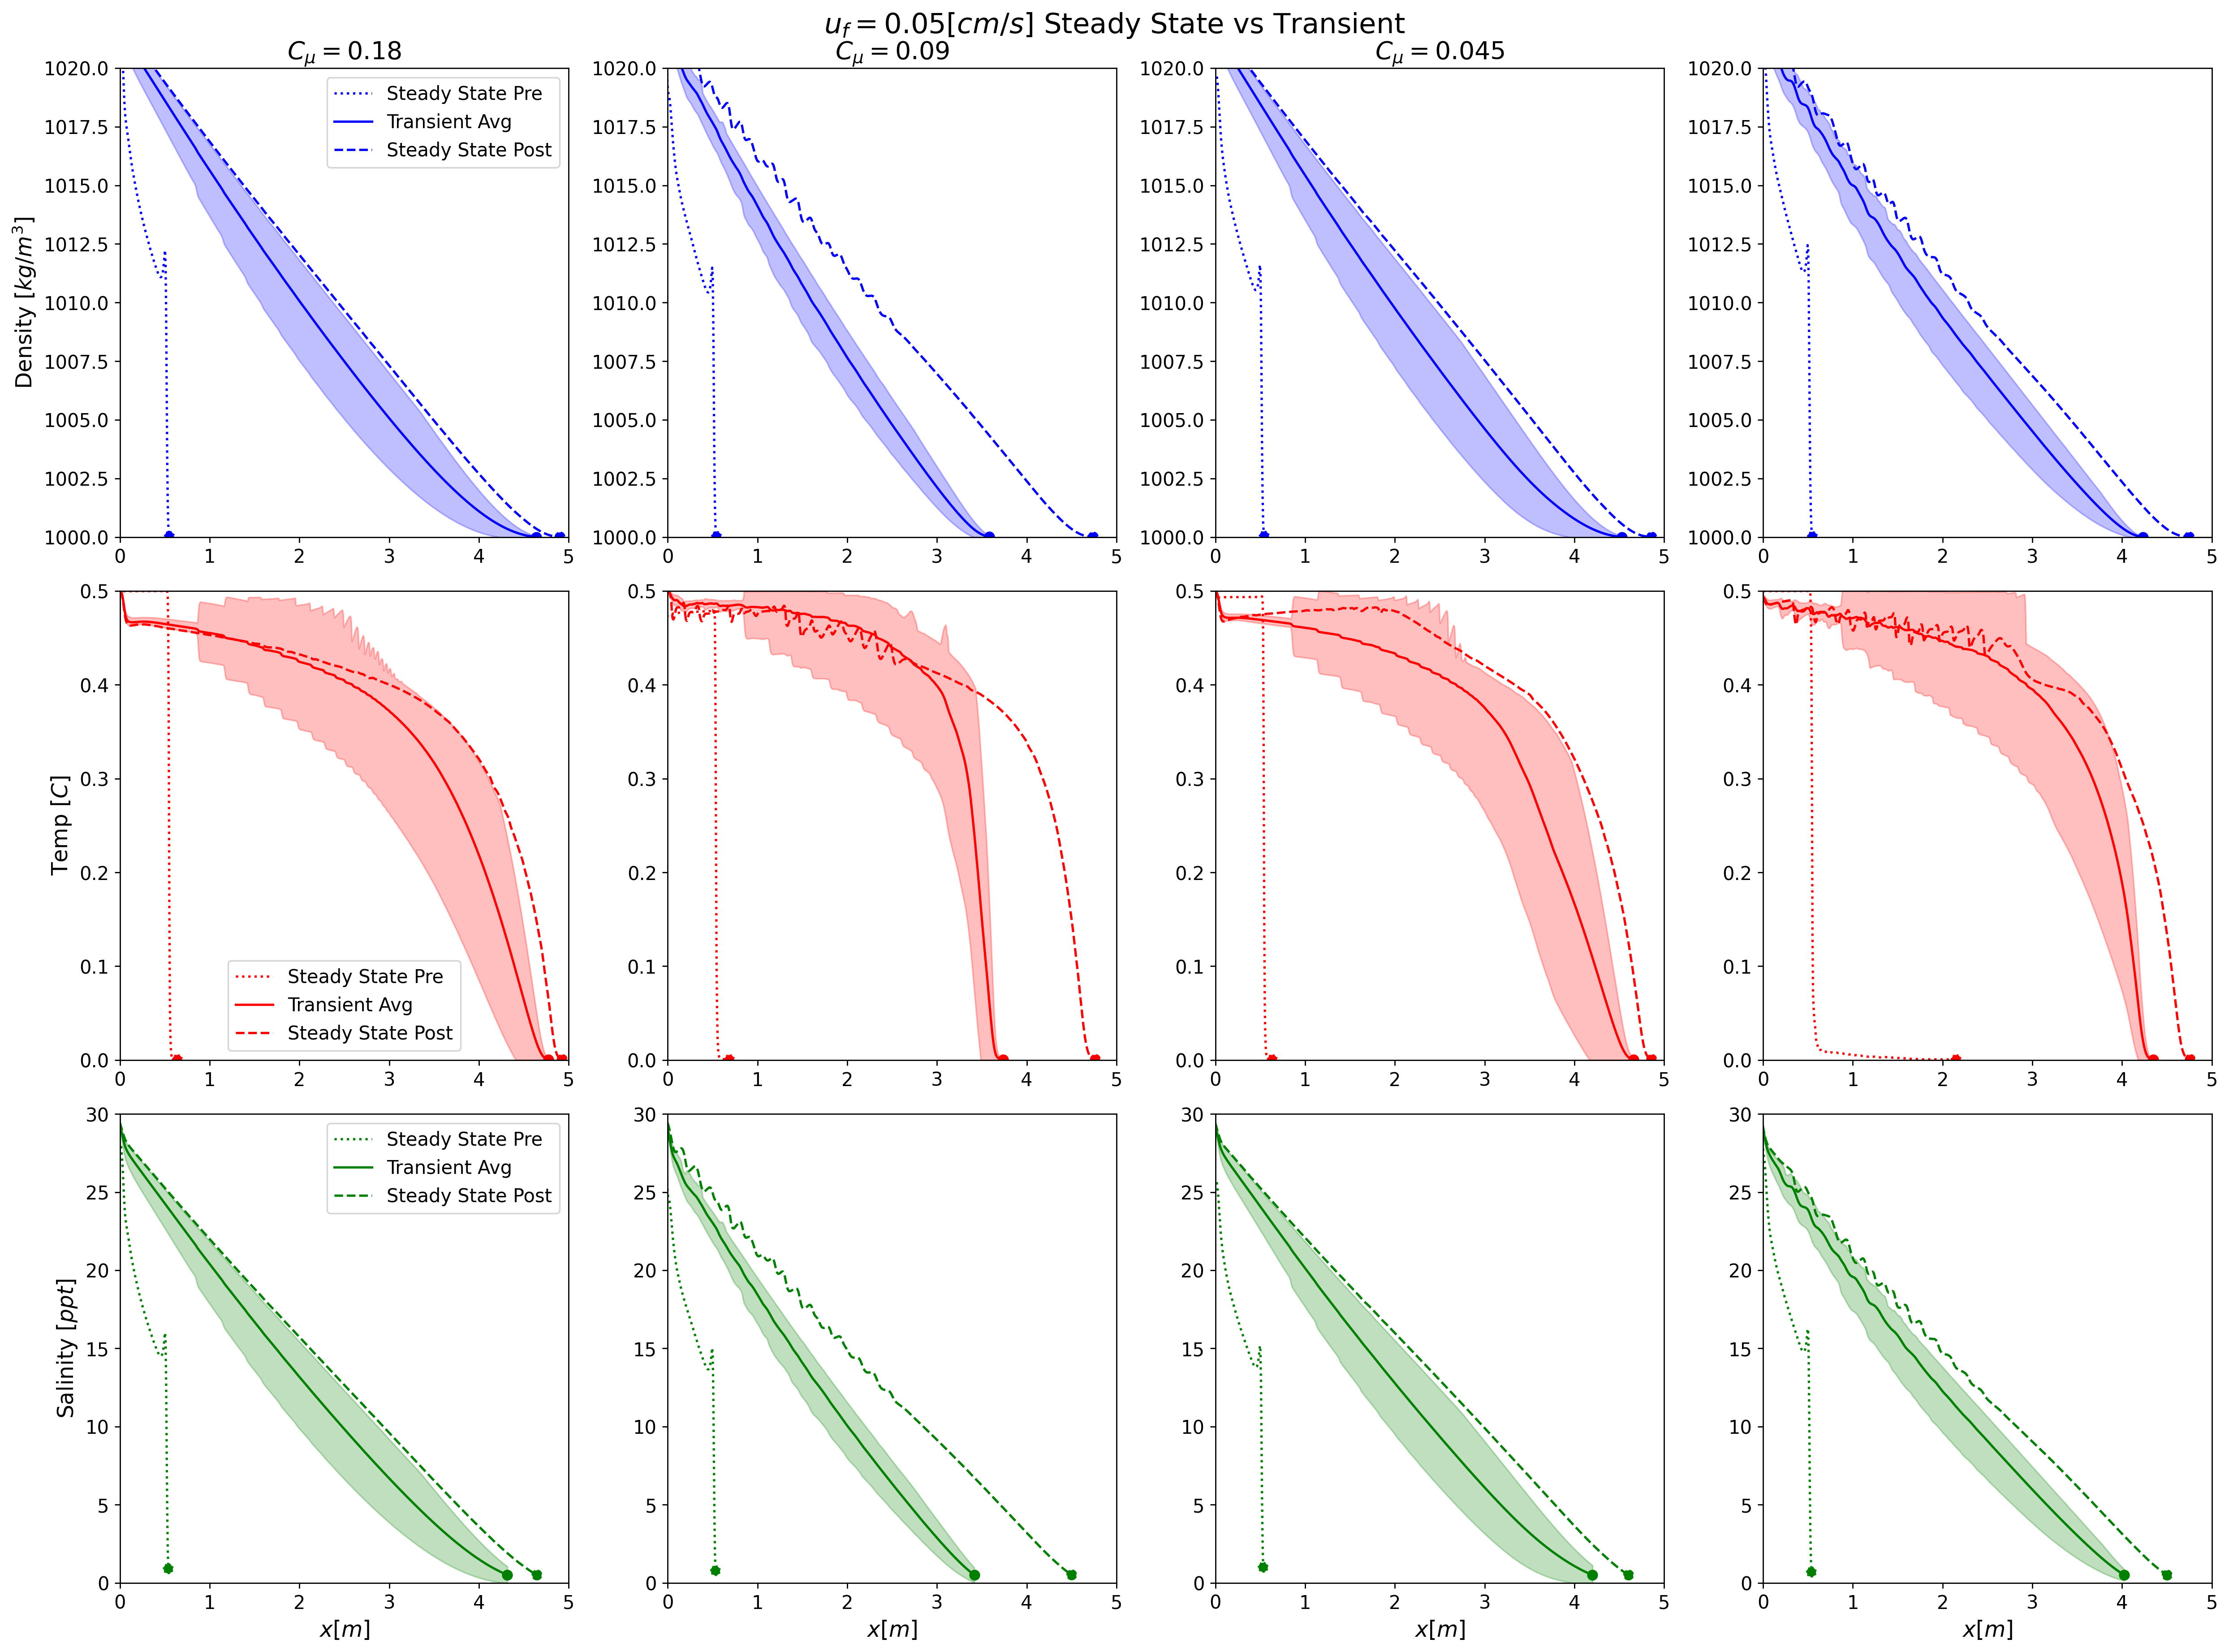

In [17]:
fig, ax = plt.subplots(3,4, figsize = (20,15), dpi = 250)

ax[0,0].plot(f3cu1_pre['x'], f3cu1_pre['dense'], color = 'blue', linestyle = ':')
ax[0,0].plot(F3cu1_intru['x'], F3cu1_intru['mean'], color = 'blue')
ax[0,0].plot(f3cu1_post['x'], f3cu1_post['dense'], color = 'blue', linestyle = '--')

ax[0,0].fill_between(F3cu1_intru['x'], F3cu1_intru['plus'], F3cu1_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,0].scatter(f3cu1_pre['x'].iloc[-1], f3cu1_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,0].scatter(F3cu1_intru['x'].iloc[-1], F3cu1_intru['mean'].iloc[-1], color = 'blue')
ax[0,0].scatter(f3cu1_post['x'].iloc[-1], f3cu1_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
##
ax[1,0].plot(f3cu1_temp_pre['x'], f3cu1_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,0].plot(F3cu1_temp_intru['x'], F3cu1_temp_intru['mean'], color = 'red')
ax[1,0].plot(f3cu1_temp_post['x'], f3cu1_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,0].fill_between(F3cu1_temp_intru['x'], F3cu1_temp_intru['plus'], F3cu1_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,0].scatter(f3cu1_temp_pre['x'].iloc[-1], f3cu1_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,0].scatter(F3cu1_temp_intru['x'].iloc[-1], F3cu1_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,0].scatter(f3cu1_temp_post['x'].iloc[-1], f3cu1_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
##
ax[2,0].plot(f3cu1_salt_pre['x'], f3cu1_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,0].plot(F3cu1_salt_intru['x'], F3cu1_salt_intru['mean'], color = 'green')
ax[2,0].plot(f3cu1_salt_post['x'], f3cu1_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,0].fill_between(F3cu1_salt_intru['x'], F3cu1_salt_intru['plus'], F3cu1_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,0].scatter(f3cu1_salt_pre['x'].iloc[-1], f3cu1_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,0].scatter(F3cu1_salt_intru['x'].iloc[-1], F3cu1_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,0].scatter(f3cu1_salt_post['x'].iloc[-1], f3cu1_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,1].plot(f3cu2_pre['x'], f3cu2_pre['dense'], color = 'blue', linestyle = ':')
ax[0,1].plot(F3cu2_intru['x'], F3cu2_intru['mean'], color = 'blue')
ax[0,1].plot(f3cu2_post['x'], f3cu2_post['dense'], color = 'blue', linestyle = '--')

ax[0,1].fill_between(F3cu2_intru['x'], F3cu2_intru['plus'], F3cu2_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,1].scatter(f3cu2_pre['x'].iloc[-1], f3cu2_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,1].scatter(F3cu2_intru['x'].iloc[-1], F3cu2_intru['mean'].iloc[-1], color = 'blue')
ax[0,1].scatter(f3cu2_post['x'].iloc[-1], f3cu2_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,1].plot(f3cu2_temp_pre['x'], f3cu2_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,1].plot(F3cu2_temp_intru['x'], F3cu2_temp_intru['mean'], color = 'red')
ax[1,1].plot(f3cu2_temp_post['x'], f3cu2_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,1].fill_between(F3cu2_temp_intru['x'], F3cu2_temp_intru['plus'], F3cu2_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,1].scatter(f3cu2_temp_pre['x'].iloc[-1], f3cu2_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,1].scatter(F3cu2_temp_intru['x'].iloc[-1], F3cu2_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,1].scatter(f3cu2_temp_post['x'].iloc[-1], f3cu2_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,1].plot(f3cu2_salt_pre['x'], f3cu2_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,1].plot(F3cu2_salt_intru['x'], F3cu2_salt_intru['mean'], color = 'green')
ax[2,1].plot(f3cu2_salt_post['x'], f3cu2_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,1].fill_between(F3cu2_salt_intru['x'], F3cu2_salt_intru['plus'], F3cu2_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,1].scatter(f3cu2_salt_pre['x'].iloc[-1], f3cu2_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,1].scatter(F3cu2_salt_intru['x'].iloc[-1], F3cu2_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,1].scatter(f3cu2_salt_post['x'].iloc[-1], f3cu2_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
## Density
ax[0,2].plot(f3cu3_pre['x'], f3cu3_pre['dense'], color = 'blue', linestyle = ':')
ax[0,2].plot(F3cu3_intru['x'], F3cu3_intru['mean'], color = 'blue')
ax[0,2].plot(f3cu3_post['x'], f3cu3_post['dense'], color = 'blue', linestyle = '--')

ax[0,2].fill_between(F3cu3_intru['x'], F3cu3_intru['plus'], F3cu3_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,2].scatter(f3cu3_pre['x'].iloc[-1], f3cu3_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,2].scatter(F3cu3_intru['x'].iloc[-1], F3cu3_intru['mean'].iloc[-1], color = 'blue')
ax[0,2].scatter(f3cu3_post['x'].iloc[-1], f3cu3_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,2].plot(f3cu3_temp_pre['x'], f3cu3_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,2].plot(F3cu3_temp_intru['x'], F3cu3_temp_intru['mean'], color = 'red')
ax[1,2].plot(f3cu3_temp_post['x'], f3cu3_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,2].fill_between(F3cu3_temp_intru['x'], F3cu3_temp_intru['plus'], F3cu3_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,2].scatter(f3cu3_temp_pre['x'].iloc[-1], f3cu3_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,2].scatter(F3cu3_temp_intru['x'].iloc[-1], F3cu3_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,2].scatter(f3cu3_temp_post['x'].iloc[-1], f3cu3_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,2].plot(f3cu3_salt_pre['x'], f3cu3_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,2].plot(F3cu3_salt_intru['x'], F3cu3_salt_intru['mean'], color = 'green')
ax[2,2].plot(f3cu3_salt_post['x'], f3cu3_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,2].fill_between(F3cu3_salt_intru['x'], F3cu3_salt_intru['plus'], F3cu3_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,2].scatter(f3cu3_salt_pre['x'].iloc[-1], f3cu3_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,2].scatter(F3cu3_salt_intru['x'].iloc[-1], F3cu3_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,2].scatter(f3cu3_salt_post['x'].iloc[-1], f3cu3_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####

#####

## Density
ax[0,3].plot(f3cu2_o1_pre['x'], f3cu2_o1_pre['dense'], color = 'blue', linestyle = ':')
ax[0,3].plot(F3cu2_o1_intru['x'], F3cu2_o1_intru['mean'], color = 'blue')
ax[0,3].plot(f3cu2_o1_post['x'], f3cu2_o1_post['dense'], color = 'blue', linestyle = '--')

ax[0,3].fill_between(F3cu2_o1_intru['x'], F3cu2_o1_intru['plus'], F3cu2_o1_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,3].scatter(f3cu2_o1_pre['x'].iloc[-1], f3cu2_o1_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,3].scatter(F3cu2_o1_intru['x'].iloc[-1], F3cu2_o1_intru['mean'].iloc[-1], color = 'blue')
ax[0,3].scatter(f3cu2_o1_post['x'].iloc[-1], f3cu2_o1_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,3].plot(f3cu2_o1_temp_pre['x'], f3cu2_o1_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,3].plot(F3cu2_o1_temp_intru['x'], F3cu2_o1_temp_intru['mean'], color = 'red')
ax[1,3].plot(f3cu2_o1_temp_post['x'], f3cu2_o1_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,3].fill_between(F3cu2_o1_temp_intru['x'], F3cu2_o1_temp_intru['plus'], F3cu2_o1_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,3].scatter(f3cu2_o1_temp_pre['x'].iloc[-1], f3cu2_o1_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,3].scatter(F3cu2_o1_temp_intru['x'].iloc[-1], F3cu2_o1_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,3].scatter(f3cu2_o1_temp_post['x'].iloc[-1], f3cu2_o1_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,3].plot(f3cu2_o1_salt_pre['x'], f3cu2_o1_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,3].plot(F3cu2_o1_salt_intru['x'], F3cu2_o1_salt_intru['mean'], color = 'green')
ax[2,3].plot(f3cu2_o1_salt_post['x'], f3cu2_o1_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,3].fill_between(F3cu2_o1_salt_intru['x'], F3cu2_o1_salt_intru['plus'], F3cu2_o1_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,3].scatter(f3cu2_o1_salt_pre['x'].iloc[-1], f3cu2_o1_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,3].scatter(F3cu2_o1_salt_intru['x'].iloc[-1], F3cu2_o1_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,3].scatter(f3cu2_o1_salt_post['x'].iloc[-1], f3cu2_o1_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
ax[0,0].set_xlim(0,5); ax[0,1].set_xlim(0,5); ax[0,2].set_xlim(0,5); ax[0,3].set_xlim(0,5);
ax[1,0].set_xlim(0,5); ax[1,1].set_xlim(0,5); ax[1,2].set_xlim(0,5); ax[1,3].set_xlim(0,5);
ax[2,0].set_xlim(0,5); ax[2,1].set_xlim(0,5); ax[2,2].set_xlim(0,5); ax[2,3].set_xlim(0,5);

ax[0,0].set_ylim(1000,1020); ax[0,1].set_ylim(1000,1020); ax[0,2].set_ylim(1000,1020); ax[0,3].set_ylim(1000,1020);
ax[1,0].set_ylim(0,0.5); ax[1,1].set_ylim(0,0.5); ax[1,2].set_ylim(0,0.5); ax[1,3].set_ylim(0,0.5);
ax[2,0].set_ylim(0,30); ax[2,1].set_ylim(0,30); ax[2,2].set_ylim(0,30); ax[2,3].set_ylim(0,30);

ax[0,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[1,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[2,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])

ax[0,0].set_title('$C_\mu = 0.18$'); ax[0,1].set_title('$C_\mu = 0.09$'); ax[0,2].set_title('$C_\mu = 0.045$'); 
ax[0,0].set_ylabel('Density $[kg/m^3]$'); ax[1,0].set_ylabel('Temp $[C]$'); ax[2,0].set_ylabel('Salinity $[ppt]$');
ax[2,0].set_xlabel('$x [m]$'); ax[2,1].set_xlabel('$x [m]$'); ax[2,2].set_xlabel('$x [m]$'); ax[2,3].set_xlabel('$x [m]$');

fig.suptitle('$u_f = 0.05 [cm/s]$ Steady State vs Transient', fontsize = 18); plt.tight_layout();
plt.savefig('f3_ss_transAvg.png',facecolor = 'white',dpi = 500)

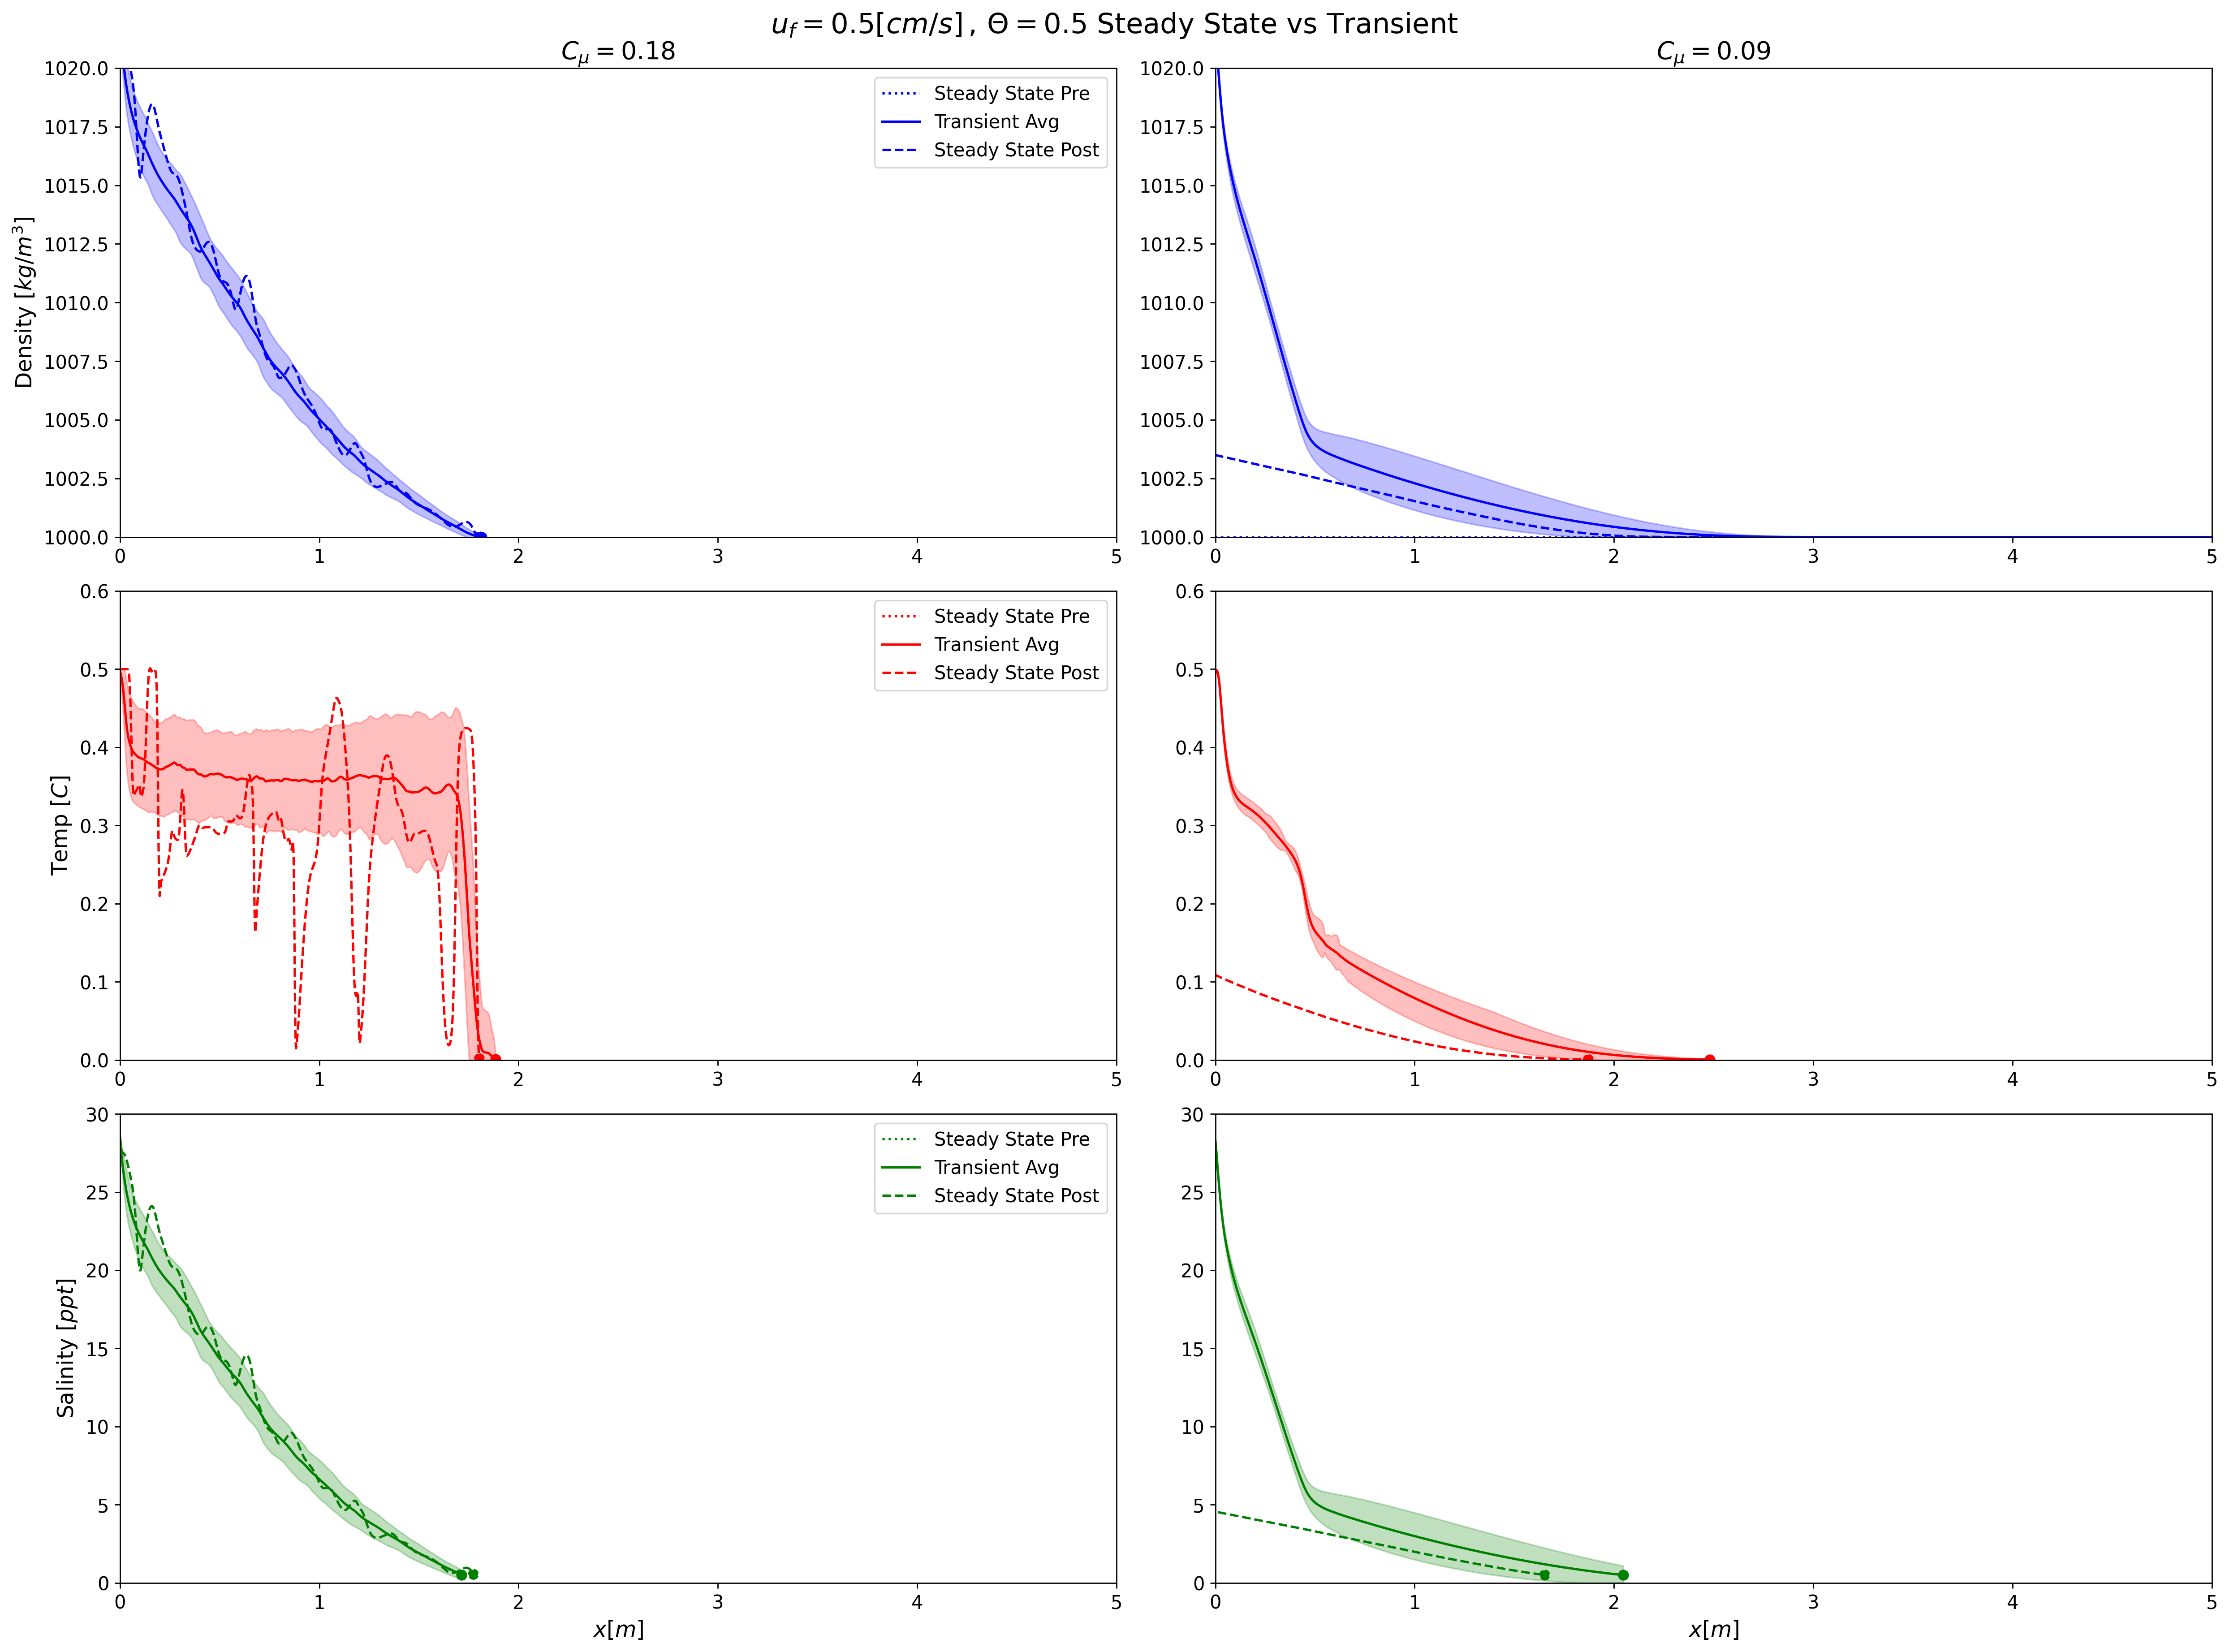

In [16]:
fig, ax = plt.subplots(3,2, figsize = (20,15), dpi = 250)

ax[0,0].plot(f4cu2_pre['x'], f4cu2_pre['dense'], color = 'blue', linestyle = ':')
ax[0,0].plot(F4cu2_intru['x'], F4cu2_intru['mean'], color = 'blue')
ax[0,0].plot(f4cu2_post['x'], f4cu2_post['dense'], color = 'blue', linestyle = '--')

ax[0,0].fill_between(F4cu2_intru['x'], F4cu2_intru['plus'], F4cu2_intru['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,0].scatter(f4cu2_pre['x'].iloc[-1], f4cu2_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,0].scatter(F4cu2_intru['x'].iloc[-1], F4cu2_intru['mean'].iloc[-1], color = 'blue')
ax[0,0].scatter(f4cu2_post['x'].iloc[-1], f4cu2_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
##
ax[1,0].plot(f4cu2_temp_pre['x'], f4cu2_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,0].plot(F4cu2_temp_intru['x'], F4cu2_temp_intru['mean'], color = 'red')
ax[1,0].plot(f4cu2_temp_post['x'], f4cu2_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,0].fill_between(F4cu2_temp_intru['x'], F4cu2_temp_intru['plus'], F4cu2_temp_intru['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,0].scatter(f4cu2_temp_pre['x'].iloc[-1], f4cu2_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,0].scatter(F4cu2_temp_intru['x'].iloc[-1], F4cu2_temp_intru['mean'].iloc[-1], color = 'red')
ax[1,0].scatter(f4cu2_temp_post['x'].iloc[-1], f4cu2_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
##
ax[2,0].plot(f4cu2_salt_pre['x'], f4cu2_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,0].plot(F4cu2_salt_intru['x'], F4cu2_salt_intru['mean'], color = 'green')
ax[2,0].plot(f4cu2_salt_post['x'], f4cu2_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,0].fill_between(F4cu2_salt_intru['x'], F4cu2_salt_intru['plus'], F4cu2_salt_intru['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,0].scatter(f4cu2_salt_pre['x'].iloc[-1], f4cu2_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,0].scatter(F4cu2_salt_intru['x'].iloc[-1], F4cu2_salt_intru['mean'].iloc[-1], color = 'green')
ax[2,0].scatter(f4cu2_salt_post['x'].iloc[-1], f4cu2_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')


#####
## Density
ax[0,1].plot(f4cu2_bf_pre['x'], f4cu2_bf_pre['dense'], color = 'blue', linestyle = ':')
ax[0,1].plot(F4cu2_intru_bf['x'], F4cu2_intru_bf['mean'], color = 'blue')
ax[0,1].plot(f4cu2_bf_post['x'], f4cu2_bf_post['dense'], color = 'blue', linestyle = '--')

ax[0,1].fill_between(F4cu2_intru_bf['x'], F4cu2_intru_bf['plus'], F4cu2_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'blue')

ax[0,1].scatter(f4cu2_bf_pre['x'].iloc[-1], f4cu2_bf_pre['dense'].iloc[-1], color = 'blue', linestyle = ':')
ax[0,1].scatter(F4cu2_intru_bf['x'].iloc[-1], F4cu2_intru_bf['mean'].iloc[-1], color = 'blue')
ax[0,1].scatter(f4cu2_bf_post['x'].iloc[-1], f4cu2_bf_post['dense'].iloc[-1], color = 'blue', linestyle = '--')
## Temperature
ax[1,1].plot(f4cu2_bf_temp_pre['x'], f4cu2_bf_temp_pre['temp'], color = 'red', linestyle = ':')
ax[1,1].plot(F4cu2_temp_intru_bf['x'], F4cu2_temp_intru_bf['mean'], color = 'red')
ax[1,1].plot(f4cu2_bf_temp_post['x'], f4cu2_bf_temp_post['temp'], color = 'red', linestyle = '--')

ax[1,1].fill_between(F4cu2_temp_intru_bf['x'], F4cu2_temp_intru_bf['plus'], F4cu2_temp_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'red')

ax[1,1].scatter(f4cu2_bf_temp_pre['x'].iloc[-1], f4cu2_bf_temp_pre['temp'].iloc[-1], color = 'red', linestyle = ':')
ax[1,1].scatter(F4cu2_temp_intru_bf['x'].iloc[-1], F4cu2_temp_intru_bf['mean'].iloc[-1], color = 'red')
ax[1,1].scatter(f4cu2_bf_temp_post['x'].iloc[-1], f4cu2_bf_temp_post['temp'].iloc[-1], color = 'red', linestyle = '--')
## Salinity
ax[2,1].plot(f4cu2_bf_salt_pre['x'], f4cu2_bf_salt_pre['salt'], color = 'green', linestyle = ':')
ax[2,1].plot(F4cu2_salt_intru_bf['x'], F4cu2_salt_intru_bf['mean'], color = 'green')
ax[2,1].plot(f4cu2_bf_salt_post['x'], f4cu2_bf_salt_post['salt'], color = 'green', linestyle = '--')

ax[2,1].fill_between(F4cu2_salt_intru_bf['x'], F4cu2_salt_intru_bf['plus'], F4cu2_salt_intru_bf['minus'], alpha = 0.25, zorder = 2, color = 'green')

ax[2,1].scatter(f4cu2_bf_salt_pre['x'].iloc[-1], f4cu2_bf_salt_pre['salt'].iloc[-1], color = 'green', linestyle = ':')
ax[2,1].scatter(F4cu2_salt_intru_bf['x'].iloc[-1], F4cu2_salt_intru_bf['mean'].iloc[-1], color = 'green')
ax[2,1].scatter(f4cu2_bf_salt_post['x'].iloc[-1], f4cu2_bf_salt_post['salt'].iloc[-1], color = 'green', linestyle = '--')

#####
ax[0,0].set_xlim(0,5); ax[0,1].set_xlim(0,5); 
ax[1,0].set_xlim(0,5); ax[1,1].set_xlim(0,5); 
ax[2,0].set_xlim(0,5); ax[2,1].set_xlim(0,5);

ax[0,0].set_ylim(1000,1020); ax[0,1].set_ylim(1000,1020); 
ax[1,0].set_ylim(0,0.6); ax[1,1].set_ylim(0,0.6);
ax[2,0].set_ylim(0,30); ax[2,1].set_ylim(0,30);

ax[0,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[1,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])
ax[2,0].legend(['Steady State Pre','Transient Avg','Steady State Post'])

ax[0,0].set_title('$C_\mu = 0.18$'); ax[0,1].set_title('$C_\mu = 0.09$'); 
ax[0,0].set_ylabel('Density $[kg/m^3]$'); ax[1,0].set_ylabel('Temp $[C]$'); ax[2,0].set_ylabel('Salinity $[ppt]$');
ax[2,0].set_xlabel('$x [m]$'); ax[2,1].set_xlabel('$x [m]$'); 

fig.suptitle('$u_f = 0.5 [cm/s] \, , \, \Theta = 0.5$ Steady State vs Transient', fontsize = 18); plt.tight_layout();
plt.savefig('f4_ss_transAvg.png',facecolor = 'white',dpi = 500)

### Scattering Intrusion Length for transient runs to intrusion length for post steady state solver. 

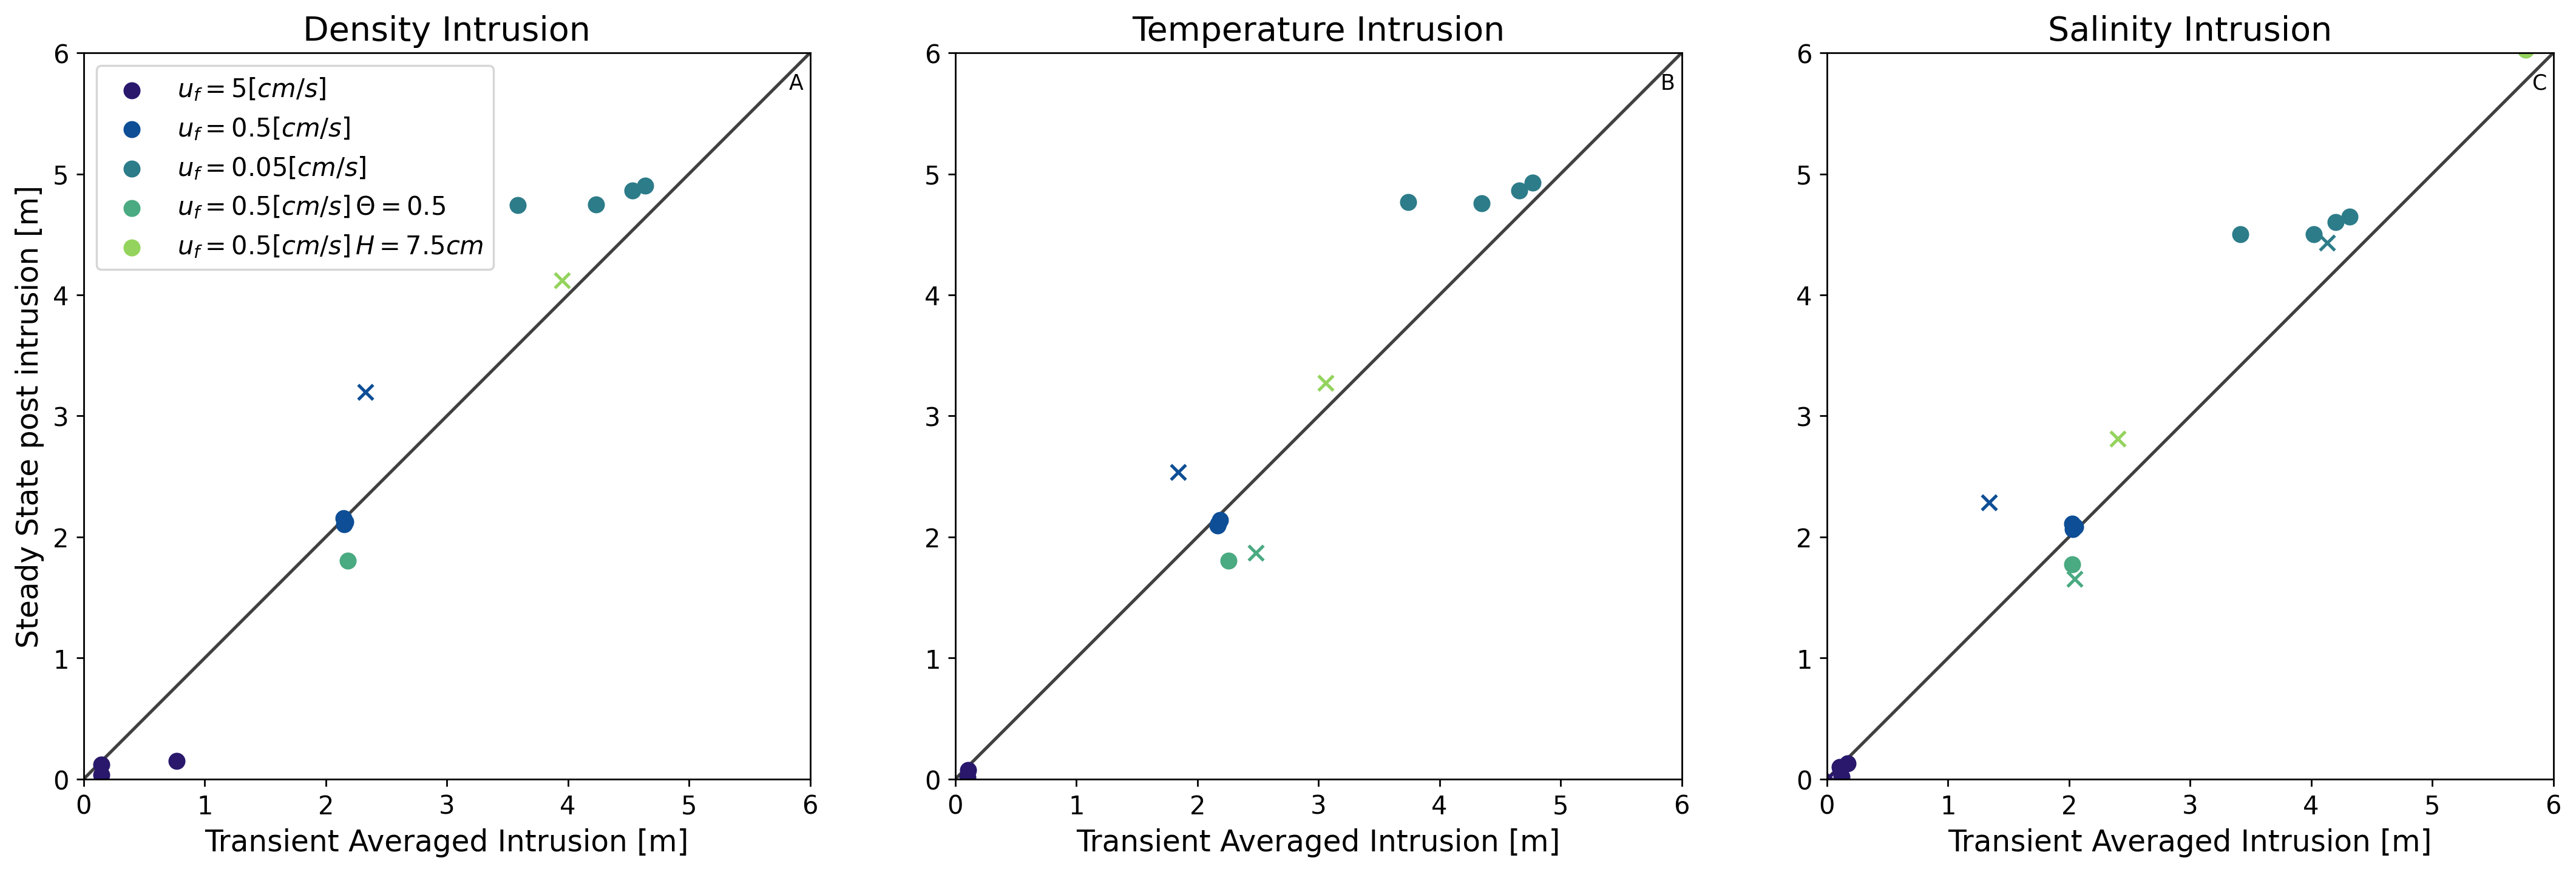

In [64]:
fig, axis = plt.subplots(1,3, figsize = (21,7), dpi = 250)

ax = axis[0]
ax1 = axis[1]
ax2 = axis[2]
colors = cmo.cm.haline(np.linspace(0,1,6))

f1 = ax.scatter(F1cu1_intru['x'].iloc[-1], f1cu1_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])
ax.scatter(F1cu2_intru['x'].iloc[-1], f1cu2_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])
ax.scatter(F1cu3_intru['x'].iloc[-1], f1cu3_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])

f2 = ax.scatter(F2cu1_intru['x'].iloc[-1], f2cu1_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax.scatter(F2cu2_intru['x'].iloc[-1], f2cu2_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax.scatter(F2cu3_intru['x'].iloc[-1], f2cu3_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax.scatter(F2cu2_intru_bf['x'].iloc[-1], f2cu2_bf_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[1])

f3 = ax.scatter(F3cu1_intru['x'].iloc[-1], f3cu1_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax.scatter(F3cu2_intru['x'].iloc[-1], f3cu2_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax.scatter(F3cu3_intru['x'].iloc[-1], f3cu3_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax.scatter(F3cu2_o1_intru['x'].iloc[-1], f3cu2_o1_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])

f4 = ax.scatter(F4cu2_intru['x'].iloc[-1], f4cu2_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[3])
ax.scatter(F4cu2_intru_bf['x'].iloc[-1], f4cu2_bf_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[3])

f5 = ax.scatter(F5cu2_intru['x'].iloc[-1], f5cu2_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[4])
ax.scatter(F5cu2_intru_bf['x'].iloc[-1], f5cu2_bf_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[4])

ax.legend([f1,f2,f3,f4,f5], ['$u_f = 5 [cm/s]$', '$u_f = 0.5 [cm/s]$', '$u_f = 0.05 [cm/s]$', '$u_f = 0.5 [cm/s] \, \Theta = 0.5$', '$u_f = 0.5 [cm/s] \, H = 7.5 cm$'])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
######
ax1.scatter(F1cu1_temp_intru['x'].iloc[-1], f1cu1_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])
ax1.scatter(F1cu2_temp_intru['x'].iloc[-1], f1cu2_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])
ax1.scatter(F1cu3_temp_intru['x'].iloc[-1], f1cu3_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])

ax1.scatter(F2cu1_temp_intru['x'].iloc[-1], f2cu1_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax1.scatter(F2cu2_temp_intru['x'].iloc[-1], f2cu2_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax1.scatter(F2cu3_temp_intru['x'].iloc[-1], f2cu3_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax1.scatter(F2cu2_temp_intru_bf['x'].iloc[-1], f2cu2_bf_temp_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[1])

ax1.scatter(F3cu1_temp_intru['x'].iloc[-1], f3cu1_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax1.scatter(F3cu2_temp_intru['x'].iloc[-1], f3cu2_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax1.scatter(F3cu3_temp_intru['x'].iloc[-1], f3cu3_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax1.scatter(F3cu2_o1_temp_intru['x'].iloc[-1], f3cu2_o1_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])

ax1.scatter(F4cu2_temp_intru['x'].iloc[-1], f4cu2_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[3])
ax1.scatter(F4cu2_temp_intru_bf['x'].iloc[-1], f4cu2_bf_temp_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[3])

ax1.scatter(F5cu2_temp_intru['x'].iloc[-1], f5cu2_temp_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[4])
ax1.scatter(F5cu2_temp_intru_bf['x'].iloc[-1], f5cu2_bf_temp_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[4])


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims)
ax1.set_ylim(lims)

######
ax2.scatter(F1cu1_salt_intru['x'].iloc[-1], f1cu1_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])
ax2.scatter(F1cu2_salt_intru['x'].iloc[-1], f1cu2_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])
ax2.scatter(F1cu3_salt_intru['x'].iloc[-1], f1cu3_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[0])

ax2.scatter(F2cu1_salt_intru['x'].iloc[-1], f2cu1_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax2.scatter(F2cu2_salt_intru['x'].iloc[-1], f2cu2_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax2.scatter(F2cu3_salt_intru['x'].iloc[-1], f2cu3_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[1])
ax2.scatter(F2cu2_salt_intru_bf['x'].iloc[-1], f2cu2_bf_salt_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[1])

ax2.scatter(F3cu1_salt_intru['x'].iloc[-1], f3cu1_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax2.scatter(F3cu2_salt_intru['x'].iloc[-1], f3cu2_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax2.scatter(F3cu3_salt_intru['x'].iloc[-1], f3cu3_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])
ax2.scatter(F3cu2_o1_salt_intru['x'].iloc[-1], f3cu2_o1_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[2])

ax2.scatter(F4cu2_salt_intru['x'].iloc[-1], f4cu2_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[3])
ax2.scatter(F4cu2_salt_intru_bf['x'].iloc[-1], f4cu2_bf_salt_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[3])

ax2.scatter(F5cu2_salt_intru['x'].iloc[-1], f5cu2_salt_post['x'].iloc[-1], marker = 'o', s = 50, color = colors[4])
ax2.scatter(F5cu2_salt_intru_bf['x'].iloc[-1], f5cu2_bf_salt_post['x'].iloc[-1], marker = 'x', s = 50, color = colors[4])
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]
ax1.set_xlim(0,6); ax1.set_ylim(0,6);
ax.set_xlim(0,6); ax.set_ylim(0,6);


ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlim(0,6); ax2.set_ylim(0,6);

ax.set_ylabel('Steady State post intrusion [m]'); ax.set_xlabel('Transient Averaged Intrusion [m]');
ax1.set_xlabel('Transient Averaged Intrusion [m]'); ax2.set_xlabel('Transient Averaged Intrusion [m]');
ax.set_title('Density Intrusion'); ax1.set_title('Temperature Intrusion'); ax2.set_title('Salinity Intrusion');
ax.text(5.825,5.7, 'A');
ax1.text(5.825,5.7, 'B');
ax2.text(5.825,5.7, 'C');

plt.savefig('ss_post_v_transient.png',dpi = 500);